<a href="https://colab.research.google.com/github/Sargam-11/ASD/blob/main/FInal%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
os.chdir("/content/drive/MyDrive/ABIDE/")


*Install all Dependencies*

In [3]:
!pip install neurocombat-sklearn
!pip install neuroHarmonize
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric
import torch



ERROR: Could not find a version that satisfies the requirement torch==1.11.0 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.11.0
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
ERROR: Could not find a version that satisfies the requirement torch-scatter (from versions: none)
ERROR: No matching distribution found for torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
ERROR: Could not find a version that satisfies the requirement torch-sparse (from versions: none)
ERROR: No matching distribution found for torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
ERROR: Could not find a version that satisfies the requirement torch-cluster (from versions: none)
ERROR: No matching distribution found for torch-cluster
Looking in l

*Import all Libraries *

In [5]:

# Load libraries
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from neurocombat_sklearn import CombatModel
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch_geometric as tg
from torch.nn import Linear as Lin, Sequential as Seq
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE


*Feature Selection*

In [6]:

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=10, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
    return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
    '''
      In some situations, the dimension on z-axis of images are smaller than
      the dimension of z-axis of patches, this function will be used to pad
    '''

    one_line = np.zeros((1, int(length)))
    position = 0
    for i in range(img.shape[0]):  # column
        for j in range(i + 1, img.shape[1]):  # row
            one_line[0, position] = img[j, i]
            position = position + 1
    return one_line

def get_ids(num_subjects=None,dir_path=''):
    """
    return:
        subject_IDs    : list of all subject IDs
    """
    subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

    if num_subjects is not None:
        subject_IDs = subject_IDs[:num_subjects]

    return subject_IDs

def save_model(net,path, name_net):
    # This function is used to save a specific model
    if not os.path.exists(path):
        os.makedirs(path)
    path_net = path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    if torch.cuda.is_available():
        net.cuda()

def load_model(net, path, name_net):
    # This function is used to load a specific model we saved before
    path_net = path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))
    return net



Load Data- Run Prep_Abide before this cell

In [7]:
fMRI_atlas = 'AAL'  # AAL or CC200
combat_fMRI = True    # True or False
combat_sMRI = True

if combat_sMRI == False:
    save_combat_sMRI = '/without_ComBat/'
else:
    save_combat_sMRI = '/with_ComBat/'

# fMRI path
save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_combat_sMRI
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
    shutil.rmtree(root_path_fMRI)
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI)
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
    shutil.rmtree(localDir)
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'

k_fold = 5
new_number_features_fMRI = 5000
new_number_features_sMRI = 1435
new_number_features_combine = 6000
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
    image_size = [116, 116]
else:
    image_size = [200, 200]
scaler = True

age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
    site = all_sites[i]
    all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

EV_GCN_unique = list(unique_sites)
EV_GCN_site = np.zeros([number_samples - len(useless_samples)], dtype=int)
EV_GCN_age = np.zeros([number_samples - len(useless_samples)], dtype=np.float32)
EV_GCN_gender = np.zeros([number_samples - len(useless_samples)], dtype=int)

position = 0
print('constructing fMRI features')
for i in range(number_samples):
    subject_name = subject_IDs[i]
    if subject_name in useless_samples:
        subject_index = get_index(lst=subject_IDs, item=subject_name)
        # print('The index for sample ' + subject_name + ' is : ', subject_index)
    else:
        image_name = subject_name + '.mat'
        subject_index = get_index(lst=subject_IDs, item=subject_name)
        image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
        img = image['connectivity']

        idx = np.triu_indices_from(img, 1)
        fMRI_images[position, :] = img[idx]
        sites.append(all_sites[subject_index[0]])
        labels[position] = label[subject_index[0]]
        genders[position] = int(gender[subject_index[0]]) + 1
        ages[position] = float(age[subject_index[0]])
        position = position + 1

for i in range(number_samples - len(useless_samples)):
    EV_GCN_site[i] = EV_GCN_unique.index(sites[i])
    EV_GCN_age[i] = float(ages[i])  # Convert to scalar
    EV_GCN_gender[i] = int(genders[i])  # Convert to scalar

phonetic_data = np.zeros([number_samples - len(useless_samples), 3], dtype=np.float32)
phonetic_data[:,0] = EV_GCN_site
phonetic_data[:,1] = EV_GCN_gender
phonetic_data[:,2] = EV_GCN_age

pd_dict = {}
pd_dict['SITE_ID'] = np.copy(phonetic_data[:,0])
pd_dict['SEX'] = np.copy(phonetic_data[:,1])
pd_dict['AGE_AT_SCAN'] = np.copy(phonetic_data[:,2])

if scaler == True:
    fMRI_images = StandardScaler().fit_transform(fMRI_images)

Streaming output truncated to the last 5000 lines.
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/aseg.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.DKTatlas.stats  


/tmp/ipython-input-3051681406.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  EV_GCN_age[i] = float(ages[i])  # Convert to scalar
/tmp/ipython-input-3051681406.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  EV_GCN_gender[i] = int(genders[i])  # Convert to scalar



Load sMRI &
Load Desikan_Killiany_features

In [8]:
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))

position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
    subject_name = subject_IDs[i]
    if subject_name in useless_samples:
        subject_index = get_index(lst=subject_IDs, item=subject_name)
        print('The index for sample ' + subject_name + ' is : ', subject_index)
    else:
        table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
                              skiprows=skiprows)
        table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
                              skiprows=skiprows)

        for j in range(len(feature_list)):
            feature_name = feature_list[j]
            left_features = table_left[feature_name].values.tolist()
            right_features = table_right[feature_name].values.tolist()
            all_features = left_features + right_features
            if len(all_features) != number_roi:
                print('The sample ' + subject_name + ' has mistake!')
            all_features = np.array(all_features)
            Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features
        position = position + 1

if scaler == True:
    for i in range(len(feature_list)):
        Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished Desikan-Killiany features')

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished Desikan-Killiany features


Load aseg features


In [9]:
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
    subject_name = subject_IDs[i]
    if subject_name in useless_samples:
        subject_index = get_index(lst=subject_IDs, item=subject_name)
        print('The index for sample ' + subject_name + ' is : ', subject_index)
    else:
        table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
                          skiprows=skiprows_aseg)
        for j in range(len(feature_list_aseg)):
            feature_name = feature_list_aseg[j]
            left_features = table_left[feature_name].values.tolist()
            if len(left_features) != number_roi_aseg:
                print('The sample ' + subject_name + ' has mistake!')
            all_features = np.array(left_features)
            aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
        position = position + 1

if scaler == True:
    for i in range(len(feature_list_aseg)):
        aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished aseg features')


constructing aseg features
The index for sample 51334 is :  [799]
finished aseg features


Load wmparc features


In [10]:
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
    subject_name = subject_IDs[i]
    if subject_name in useless_samples:
        subject_index = get_index(lst=subject_IDs, item=subject_name)
        print('The index for sample ' + subject_name + ' is : ', subject_index)
    else:
        table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
                          skiprows=skiprows_wmparc)
        for j in range(len(feature_list_wmparc)):
            feature_name = feature_list_wmparc[j]
            left_features = table_left[feature_name].values.tolist()
            if len(left_features) != number_roi_wmparc:
                print('The sample ' + subject_name + ' has mistake!')
            all_features = np.array(left_features)
            wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features
        position = position + 1

if scaler == True:
    for i in range(len(feature_list_wmparc)):
        wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished wmparc features')


constructing wmparc features
The index for sample 51334 is :  [799]
finished wmparc features


 concatenation


sMRI features shape: (870, 1417)
fMRI features shape: (870, 6670)


<Figure size 1000x800 with 0 Axes>

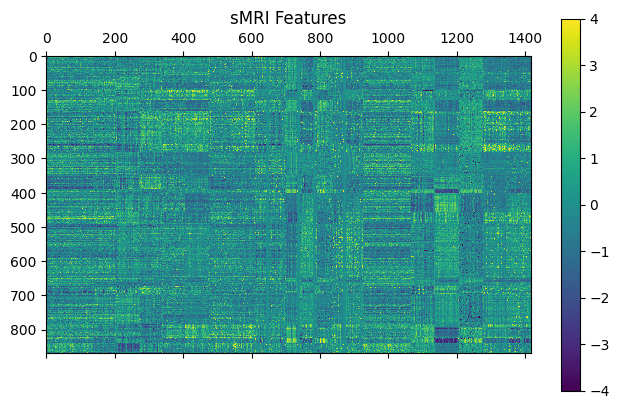

In [11]:
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)
print('sMRI features shape:', sMRI_features.shape)
print('fMRI features shape:', fMRI_images.shape)
plt.figure(figsize=(10, 8))
plt.matshow(sMRI_features, vmin=-4, vmax=4)
plt.colorbar()
plt.title('sMRI Features')
plt.show()


Combat

Attempting ComBat harmonization...


/tmp/ipython-input-657622285.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combat_genders.append(int(genders[i]))
/tmp/ipython-input-657622285.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combat_ages.append(float(ages[i]))


 Running ComBat for fMRI with original neuroCombat...
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
 fMRI ComBat completed
 Running ComBat for sMRI with original neuroCombat...
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
 sMRI ComBat completed
TYPE check – fMRI: <class 'numpy.ndarray'>
TYPE check – covars_df: <class 'pandas.core.frame.DataFrame'>
Is SITE_ID column present?: True


/usr/local/lib/python3.11/dist-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


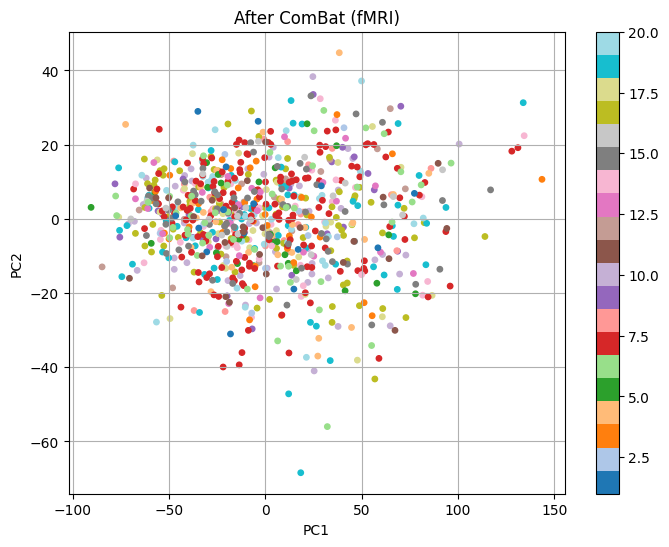

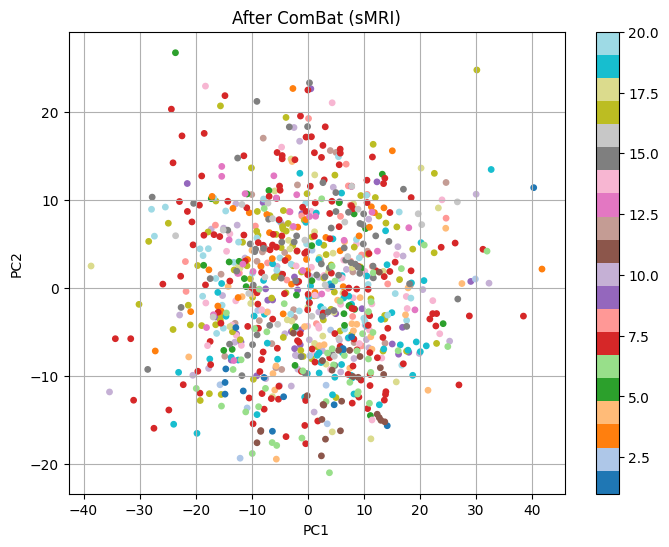

fMRI NaNs: 0
sMRI NaNs: 0


In [12]:

print("Attempting ComBat harmonization...")

# Option 1: Try installing and using the original neuroCombat
try:
    # First try to install neuroCombat
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "neuroCombat"])

    from neuroCombat import neuroCombat

    # Prepare batch and covariates for original neuroCombat
    batch = []
    for site in sites:
        batch.append(EV_GCN_unique.index(site) + 1)

    combat_labels = []
    combat_genders = []
    combat_ages = []
    for i in range(len(labels)):
        combat_labels.append(int(labels[i]) + 1)
        combat_genders.append(int(genders[i]))
        combat_ages.append(float(ages[i]))

    # Create covariates dictionary
    covars = {}
    covars['batch'] = batch
    covars['labels'] = combat_labels
    covars['genders'] = combat_genders
    covars['ages'] = combat_ages
    covars = pd.DataFrame(covars)

    # Specify categorical and continuous variables
    categorical_cols = ['labels', 'genders']
    batch_col = 'batch'
    continuous_cols = ['ages']

    if combat_fMRI:
        print(' Running ComBat for fMRI with original neuroCombat...')
        fMRI_transposed = fMRI_images.T  # neuroCombat expects features x samples
        fMRI_harmonized = neuroCombat(dat=fMRI_transposed,
                                     covars=covars,
                                     batch_col=batch_col,
                                     categorical_cols=categorical_cols,
                                     continuous_cols=continuous_cols)["data"]
        fMRI_images = fMRI_harmonized.T  # Transpose back to samples x features
        print(" fMRI ComBat completed")

    if combat_sMRI:
        print(' Running ComBat for sMRI with original neuroCombat...')
        sMRI_transposed = sMRI_features.T  # neuroCombat expects features x samples
        sMRI_harmonized = neuroCombat(dat=sMRI_transposed,
                                     covars=covars,
                                     batch_col=batch_col,
                                     categorical_cols=categorical_cols,
                                     continuous_cols=continuous_cols)["data"]
        sMRI_features = sMRI_harmonized.T  # Transpose back to samples x features
        print(" sMRI ComBat completed")

except Exception as e:
    print(f" Could not run ComBat harmonization: {e}")
    print("  Proceeding without ComBat harmonization...")
    print("   Data will not be harmonized across sites, which may affect results.")
    print("   You can manually install neuroCombat later if needed.")

    # Continue without ComBat - this is still valid for analysis
    combat_fMRI = False
    combat_sMRI = False

print("TYPE check – fMRI:", type(fMRI_images))

# Create a simple covariates dataframe for the PCA visualization
covars_df = pd.DataFrame({
    'SITE_ID': [EV_GCN_unique.index(site) + 1 for site in sites],
    'LABEL': (labels + 1).astype(int),
    'SEX': genders.flatten().astype(int),
    'AGE_AT_SCAN': ages.flatten().astype(float)
})

print("TYPE check – covars_df:", type(covars_df))
print("Is SITE_ID column present?:", 'SITE_ID' in covars_df.columns)

from sklearn.decomposition import PCA


def plot_pca(data, labels, title='PCA'):
    pca = PCA(n_components=2)
    components = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='tab20', s=15)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar()
    plt.grid(True)
    plt.show()

# After ComBat
plot_pca(fMRI_images, covars_df['SITE_ID'], title='After ComBat (fMRI)')
plot_pca(sMRI_features, covars_df['SITE_ID'], title='After ComBat (sMRI)')

print("fMRI NaNs:", np.isnan(fMRI_images).sum())
print("sMRI NaNs:", np.isnan(sMRI_features).sum())

phenotypic

In [13]:
# Load phenotypic data
ages_name = 'ages.mat'
ages_data = scio.loadmat(os.path.join(label_dir, ages_name))
ages_data = ages_data['ages']

gender_name = 'genders.mat'
genders_data = scio.loadmat(os.path.join(label_dir, gender_name))
genders_data = genders_data['genders']

FIQ_name = 'FIQS.mat'
FIQS = scio.loadmat(os.path.join(label_dir, FIQ_name))
FIQS = FIQS['FIQS']

NUM_name = 'NUM.mat'
NUM = scio.loadmat(os.path.join(label_dir, NUM_name))
NUMS = NUM['NUM']

PEC_name = 'PEC.mat'
PEC = scio.loadmat(os.path.join(label_dir, PEC_name))
PECS = PEC['PEC']

RAT_name = 'RAT.mat'
RAT = scio.loadmat(os.path.join(label_dir, RAT_name))
RATS = RAT['RAT']

age_pheno = np.zeros((number_samples - len(useless_samples), 1))
gender_pheno = np.zeros((number_samples - len(useless_samples), 1))
FIQ = np.zeros((number_samples - len(useless_samples), 1))
NUM = np.zeros((number_samples - len(useless_samples), 1))
PEC = np.zeros((number_samples - len(useless_samples), 1))
RAT = np.zeros((number_samples - len(useless_samples), 1))

position = 0
print('constructing phenotypic features')
for i in range(number_samples):
    subject_name = subject_IDs[i]
    if subject_name in useless_samples:
        subject_index = get_index(lst=subject_IDs, item=subject_name)
        print('The index for sample ' + subject_name + ' is : ', subject_index)
    else:
        subject_index = get_index(lst=subject_IDs, item=subject_name)
        age_pheno[position] = float(str(ages_data[subject_index[0]]).replace(' ', ''))
        gender_pheno[position] = int(genders_data[subject_index[0]]) + 1
        FIQ[position] = int(FIQS[subject_index[0]])
        NUM[position] = float(NUMS[subject_index[0]])
        PEC[position] = float(PECS[subject_index[0]])
        RAT[position] = int(RATS[subject_index[0]])
        position = position + 1

FIQ[FIQ == -9999] = 108

if scaler == True:
    age_pheno[:,0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(age_pheno[:,0], axis = 1)))
    FIQ[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(FIQ[:, 0], axis = 1)))
    NUM[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(NUM[:, 0], axis = 1)))
    PEC[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(PEC[:, 0], axis = 1)))

# age, gender, FIQ, NUM, PEC, RAT - Repeat 3 times as in original
for i in range(3):
    sMRI_features = np.concatenate((sMRI_features, age_pheno, gender_pheno, FIQ, NUM, PEC, RAT),axis = 1)

# Initialize fold distributions
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []

for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label_site = np.zeros((len(index_site)))
    for i in range(len(index_site)):
        index = index_site[i]
        label_site[i] = int(labels[int(index)])

    # StratifiedKFold
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site, label_site):
        for i in train:
            dist_train[str(group + 1)].append(index_site[i])
        for j in validation:
            dist_validation[str(group + 1)].append(index_site[j])
        group = group + 1

    group = 0
    for train, validation in sfolder.split(index_site, label_site):
        if group == 0:
            for j in validation:
                dist_test[str(group + k_fold)].append(index_site[j])
                if index_site[j] in dist_train[str(group + k_fold)]:  # Fixed logic
                    dist_train[str(group + k_fold)].remove(index_site[j])
        else:
            for j in validation:
                dist_test[str(group)].append(index_site[j])
                if index_site[j] in dist_train[str(group)]:  # Fixed logic
                    dist_train[str(group)].remove(index_site[j])
        group = group + 1

for i in range(k_fold):
    print(f'Fold {i+1} test size:', len(dist_test[str(i+1)]))



constructing phenotypic features
The index for sample 51334 is :  [799]
Fold 1 test size: 177
Fold 2 test size: 174
Fold 3 test size: 170
Fold 4 test size: 167
Fold 5 test size: 182


/tmp/ipython-input-2242803477.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  FIQ[position] = int(FIQS[subject_index[0]])
/tmp/ipython-input-2242803477.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  NUM[position] = float(NUMS[subject_index[0]])
/tmp/ipython-input-2242803477.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PEC[position] = float(PECS[subject_index[0]])
/tmp/ipython-input-2242803477.py:47: DeprecationWarning: Conversion of an array with

PAE and EV-GCN

In [14]:
class PAE(torch.nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(PAE, self).__init__()
        hidden=128
        self.parser =nn.Sequential(
                nn.Linear(input_dim, hidden, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden),
                nn.Dropout(dropout),
                nn.Linear(hidden, hidden, bias=True),
                )
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-8)
        self.input_dim = input_dim
        self.model_init()
        self.relu = nn.ReLU(inplace=True)
        self.elu = nn.ReLU()

    def forward(self, x):
        x1 = x[:,0:self.input_dim]
        x2 = x[:,self.input_dim:]
        h1 = self.parser(x1)
        h2 = self.parser(x2)
        p = (self.cos(h1,h2) + 1)*0.5
        return p

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

class EV_GCN(torch.nn.Module):
    def __init__(self, input_dim, num_classes, dropout, edgenet_input_dim, edge_dropout, hgc, lg):
        super(EV_GCN, self).__init__()
        K=2
        hidden = [hgc for i in range(lg)]
        self.dropout = dropout
        self.edge_dropout = edge_dropout
        bias = False
        self.relu = torch.nn.ReLU(inplace=True)
        self.lg = lg
        self.gconv = nn.ModuleList()
        for i in range(lg):
            in_channels = input_dim if i==0  else hidden[i-1]
            self.gconv.append(tg.nn.ChebConv(in_channels, hidden[i], K, normalization='sym', bias=bias))
        cls_input_dim = sum(hidden)

        self.cls = nn.Sequential(
                torch.nn.Linear(cls_input_dim, 256),
                torch.nn.ReLU(inplace=True),
                nn.BatchNorm1d(256),
                torch.nn.Linear(256, num_classes))

        self.edge_net = PAE(input_dim=edgenet_input_dim//2, dropout=dropout)
        self.model_init()
        self.softmax = nn.LogSoftmax(dim=1)

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, features, edge_index, edgenet_input, enforce_edropout=False):
        if self.edge_dropout>0:
            if enforce_edropout or self.training:
                one_mask = torch.ones([edgenet_input.shape[0],1]).cuda() if torch.cuda.is_available() else torch.ones([edgenet_input.shape[0],1])
                self.drop_mask = F.dropout(one_mask, self.edge_dropout, True)
                self.bool_mask = torch.squeeze(self.drop_mask.type(torch.bool))
                edge_index = edge_index[:, self.bool_mask]
                edgenet_input = edgenet_input[self.bool_mask]

        edge_weight = torch.squeeze(self.edge_net(edgenet_input))
        features = F.dropout(features, self.dropout, self.training)
        h = self.relu(self.gconv[0](features, edge_index, edge_weight))
        h0 = h
        for i in range(1, self.lg):
            h = F.dropout(h, self.dropout, self.training)
            h= self.relu(self.gconv[i](h, edge_index, edge_weight))
            jk = torch.cat((h0, h), axis=1)
            h0 = jk
        logit = self.cls(jk)

        return self.softmax(logit), edge_weight

EV_GCN_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        EV_GCN_labels[i,0] = 1
    else:
        EV_GCN_labels[i,1] = 1

all_subject_IDs = get_ids(number_samples,dir_path=label_dir)
all_subject_IDs = all_subject_IDs.tolist()
for i in useless_samples:
    if i in subject_IDs:  # Fixed: check if exists before removing
        subject_IDs.remove(i)

from scipy.spatial import distance

def create_affinity_graph_from_scores(scores, pd_dict):
    num_nodes = len(pd_dict[scores[0]])
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = pd_dict[l]

        if l in ['AGE_AT_SCAN', 'FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[k]) - float(label_dict[j]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except (ValueError, TypeError):  # missing label or invalid type
                        pass
        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[k] == label_dict[j]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

def get_static_affinity_adj(features, pd_dict):
    pd_affinity = create_affinity_graph_from_scores(['SEX', 'SITE_ID'], pd_dict)
    distv = distance.pdist(features, metric='correlation')
    dist = distance.squareform(distv)
    sigma = np.mean(dist)
    feature_sim = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adj = pd_affinity * feature_sim
    return adj

# Prepare data for each fold
data = {}
for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)

    # Combine features
    sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
    selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
    fold_data = selector_combine.transform(sMRI_fMRI_combine)

    n = fold_data.shape[0]
    num_edge = n * n
    edge_index = np.zeros([2, num_edge], dtype=np.int64)
    edgenet_input = np.zeros([num_edge, 2*phonetic_data.shape[1]], dtype=np.float32)
    aff_score = np.zeros(num_edge, dtype=np.float32)

    aff_adj = get_static_affinity_adj(fold_data, pd_dict)

    # Create complete graph
    flatten_ind = 0
    for i in range(n):
        for j in range(n):
            edge_index[:, flatten_ind] = [i, j]
            edgenet_input[flatten_ind] = np.concatenate((phonetic_data[i], phonetic_data[j]))
            aff_score[flatten_ind] = aff_adj[i][j]
            flatten_ind += 1

    keep_ind = np.where(aff_score > 1.1)[0]
    edge_index = edge_index[:, keep_ind]
    edgenet_input = edgenet_input[keep_ind]
    edgenet_input = (edgenet_input- edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)

    print(f'Fold {fold} data shape:', fold_data.shape)
    data[str(fold)].append(fold_data)
    data[str(fold)].append(EV_GCN_labels)
    data[str(fold)].append(edge_index)
    data[str(fold)].append(edgenet_input)


Fitting estimator with 6670 features.
Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting estimator with 6170 features.
Fitting estimator with 6070 features.
Fitting estimator with 5970 features.
Fitting estimator with 5870 features.
Fitting estimator with 5770 features.
Fitting estimator with 5670 features.
Fitting estimator with 5570 features.
Fitting estimator with 5470 features.
Fitting estimator with 5370 features.
Fitting estimator with 5270 features.
Fitting estimator with 5170 features.
Fitting estimator with 5070 features.
Fitting estimator with 6435 features.
Fitting estimator with 6335 features.
Fitting estimator with 6235 features.
Fitting estimator with 6135 features.
Fitting estimator with 6035 features.
Fold 1 data shape: (870, 6000)
Fitting estimator with 6670 features.
Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator w

Train, validation, test pipelines

In [15]:
def train_EV_GCN(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):
    model.train()
    data_tensor = torch.from_numpy(all_data[0])
    data_tensor = Variable(data_tensor, requires_grad=True)
    data_tensor = data_tensor.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=True)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data_tensor, target, edge_index, edgenet_input = data_tensor.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    scheduler.zero_grad()
    out, _ = model(data_tensor, edge_index, edgenet_input)
    out = out[fold_train_index,:]
    target = target[fold_train_index, :]

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    cross_loss.backward()
    scheduler.step()

    # Validation and test
    val_target, val_out, val_loss = validation_EV_GCN(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_EV_GCN(args, model, all_data, fold_test_index)

    return model, target, out, cross_loss.item(), val_target, val_out, val_loss, test_target, test_out, test_out_prob, test_loss

def validation_EV_GCN(args, model,all_data, fold_validation_index):
    model.eval()
    data_tensor = torch.from_numpy(all_data[0])
    data_tensor = Variable(data_tensor, requires_grad=False)
    data_tensor = data_tensor.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data_tensor, target, edge_index, edgenet_input = data_tensor.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data_tensor, edge_index, edgenet_input)
    out = out[fold_validation_index, :]
    target = target[fold_validation_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, cross_loss.item()

def test_EV_GCN(args, model, all_data, fold_test_index):
    model.eval()

    data_tensor = torch.from_numpy(all_data[0])
    data_tensor = Variable(data_tensor, requires_grad=False)
    data_tensor = data_tensor.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data_tensor, target, edge_index, edgenet_input = data_tensor.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data_tensor, edge_index, edgenet_input)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    return target, out, out_prob, cross_loss.item()

Training setting

In [16]:
torch.cuda.empty_cache()
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--input_dimension', type=int, default=new_number_features_combine)
parser.add_argument('--hgc', type=int, default=16, help='hidden units of gconv layer')
parser.add_argument('--lg', type=int, default=4, help='number of gconv layers')
parser.add_argument('--lr', default=0.01, type=float, help='initial learning rate')
parser.add_argument('--wd', default=5e-5, type=float, help='weight decay')
parser.add_argument('--num_iter', default=300, type=int, help='number of epochs for training')
parser.add_argument('--edropout', type=float, default=0.3, help='edge dropout rate')
parser.add_argument('--dropout', default=0.2, type=float, help='ratio of dropout')
parser.add_argument('--num_classes', type=int, default=2, help='number of classes')

args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

gpu_ids = range(args.ngpu)
train = train_EV_GCN


Training

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 1.16266954	 train accuracy : 0.49902153	 val accuracy : 0.47802198	 test accuracy : 0.48022599	
Save models
Train Epoch: 2: train loss : 1.06844902	 train accuracy : 0.52250489	 val accuracy : 0.50549451	 test accuracy : 0.44067797	
Save models
Train Epoch: 3: train loss : 1.28783822	 train accuracy : 0.49119374	 val accuracy : 0.58241758	 test accuracy : 0.49152542	
Train Epoch: 4: train loss : 0.93148708	 train accuracy : 0.52837573	 val accuracy : 0.54945055	 test accuracy : 0.60451977	
Save models
Train Epoch: 5: train loss : 0.91087538	 train accuracy : 0.58512720	 val accuracy : 0.59340659	 test accuracy : 0.62146893	
Train Epoch: 6: train loss : 0.79645145	 train accuracy : 0.60273973	 val accuracy : 0.53846154	 test accuracy : 0.54237288	
Train Epoch: 7: train loss : 0.76640409	 train accuracy : 0.63405088	 val accuracy : 0.56043956	 test accuracy : 0.55367232	
Train Epoch: 8: train loss : 0.77636456	 train a

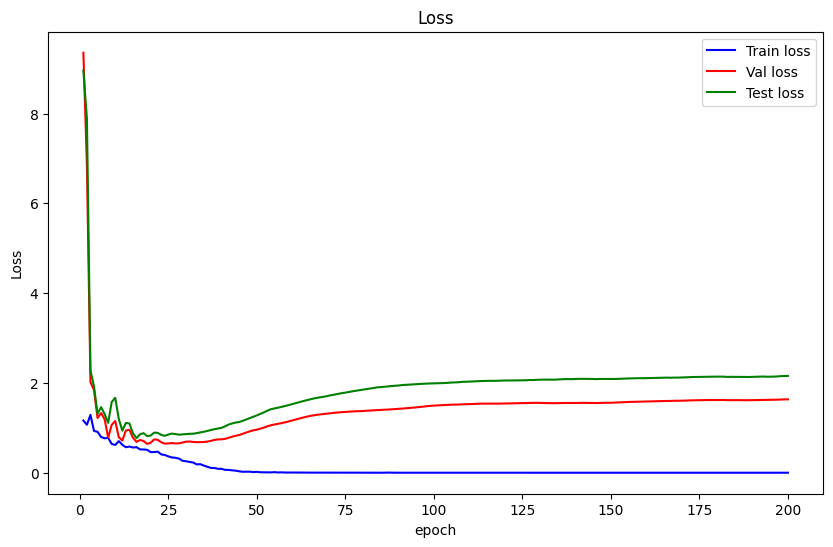

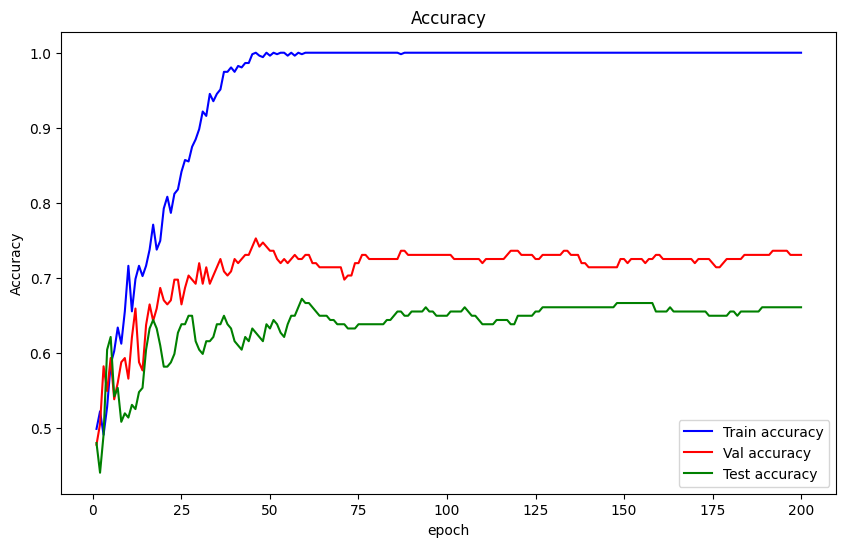



In fold  1
The best validaiton accuracy is:  0.7527472527472527
Happened at epoch:  46
The corresponding test accuracy 0.6271186440677966
The corresponding test AUC is:  0.6979539641943735




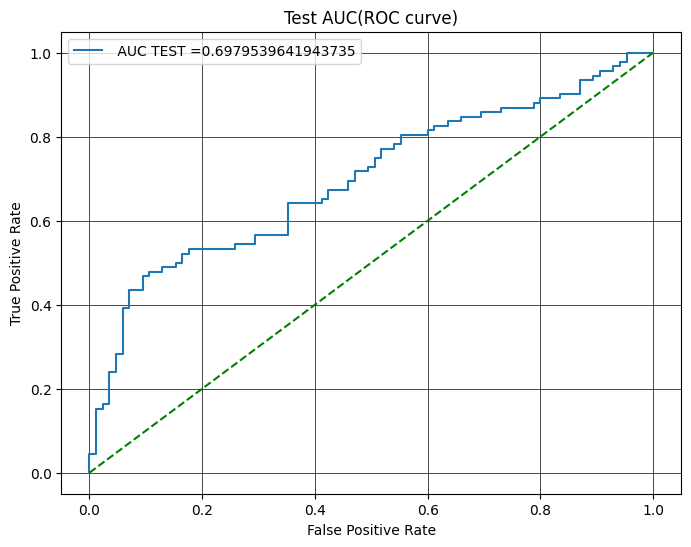

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 0.93294251	 train accuracy : 0.49710983	 val accuracy : 0.58757062	 test accuracy : 0.48850575	
Train Epoch: 2: train loss : 0.93622482	 train accuracy : 0.42581888	 val accuracy : 0.49152542	 test accuracy : 0.47126437	
Train Epoch: 3: train loss : 0.87990433	 train accuracy : 0.52986513	 val accuracy : 0.48022599	 test accuracy : 0.53448276	
Train Epoch: 4: train loss : 0.81401289	 train accuracy : 0.57032755	 val accuracy : 0.55932203	 test accuracy : 0.59770115	
Save models
Train Epoch: 5: train loss : 0.64951015	 train accuracy : 0.65317919	 val accuracy : 0.63276836	 test accuracy : 0.54597701	
Save models
Train Epoch: 6: train loss : 0.62771893	 train accuracy : 0.67437380	 val accuracy : 0.63276836	 test accuracy : 0.51149425	
Save models
Train Epoch: 7: train loss : 0.62376159	 train accuracy : 0.67630058	 val accuracy : 0.68361582	 test accuracy : 0.63218391	
Train Epoch: 8: train loss : 0.59334648	 train a

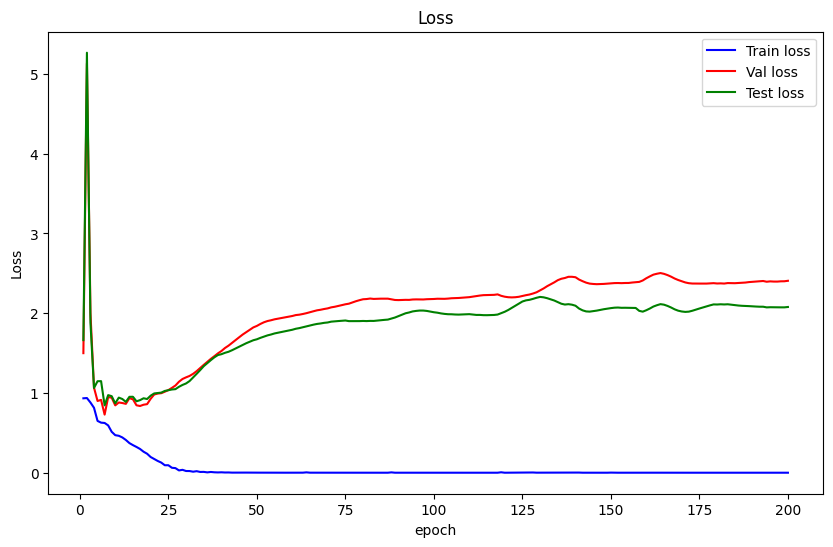

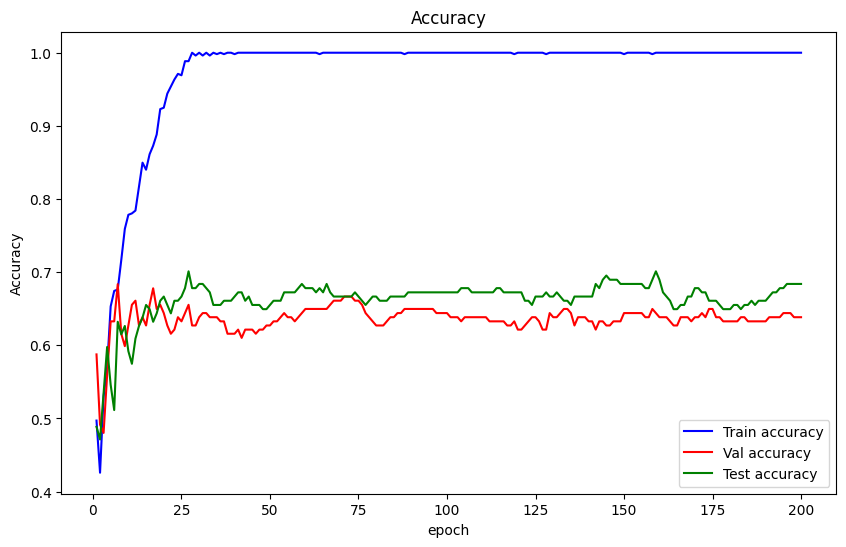



In fold  2
The best validaiton accuracy is:  0.6836158192090396
Happened at epoch:  7
The corresponding test accuracy 0.632183908045977
The corresponding test AUC is:  0.6523297491039427




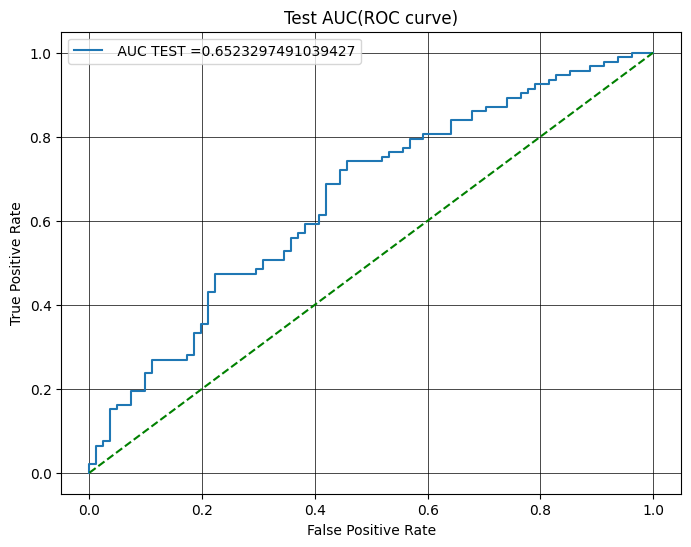

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 0.98897177	 train accuracy : 0.49809886	 val accuracy : 0.52873563	 test accuracy : 0.52941176	
Train Epoch: 2: train loss : 0.95670033	 train accuracy : 0.47528517	 val accuracy : 0.48275862	 test accuracy : 0.59411765	
Save models
Train Epoch: 3: train loss : 1.11933315	 train accuracy : 0.54562738	 val accuracy : 0.56321839	 test accuracy : 0.50000000	
Train Epoch: 4: train loss : 0.72028106	 train accuracy : 0.62167300	 val accuracy : 0.54022989	 test accuracy : 0.46470588	
Train Epoch: 5: train loss : 0.84834832	 train accuracy : 0.57414449	 val accuracy : 0.55747126	 test accuracy : 0.50000000	
Train Epoch: 6: train loss : 0.65400118	 train accuracy : 0.62167300	 val accuracy : 0.55747126	 test accuracy : 0.65294118	
Train Epoch: 7: train loss : 0.63223994	 train accuracy : 0.70722433	 val accuracy : 0.52873563	 test accuracy : 0.63529412	
Save models
Train Epoch: 8: train loss : 0.63622588	 train accuracy : 0.

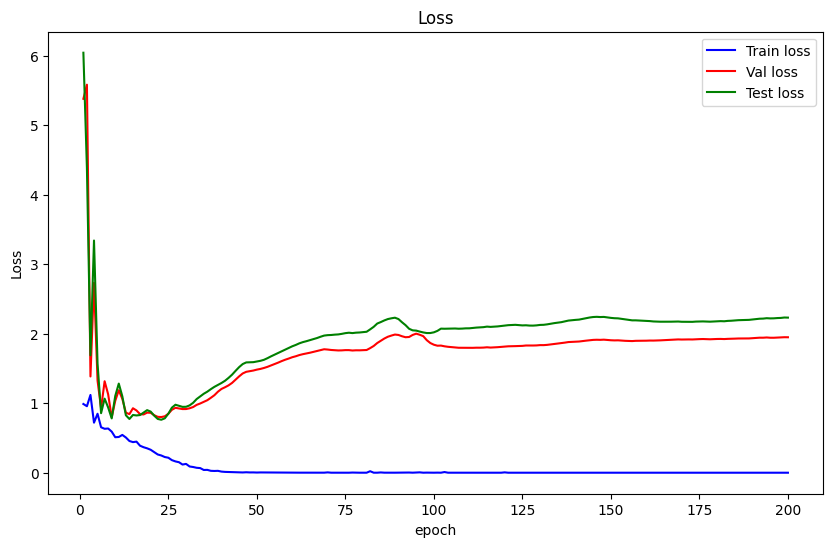

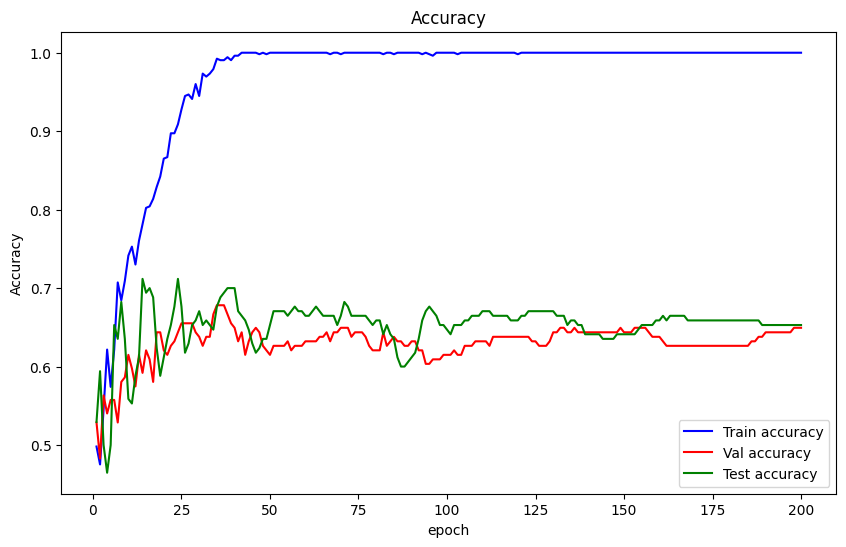



In fold  3
The best validaiton accuracy is:  0.6781609195402298
Happened at epoch:  37
The corresponding test accuracy 0.6941176470588235
The corresponding test AUC is:  0.6958286674132138




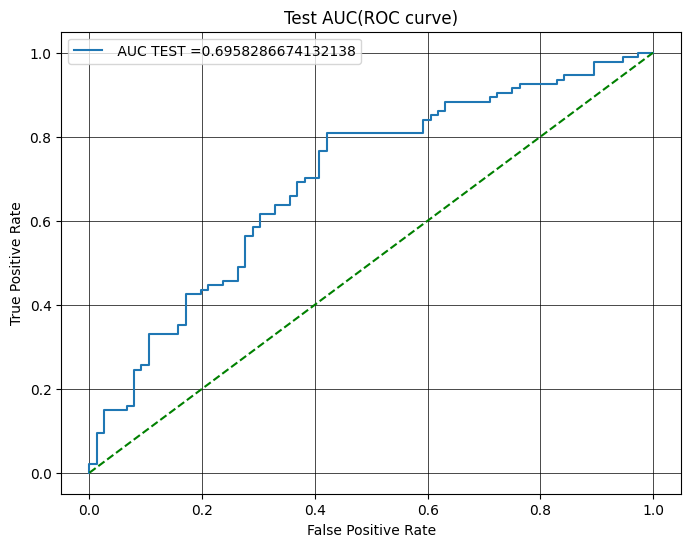

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 1.02934062	 train accuracy : 0.49343340	 val accuracy : 0.49411765	 test accuracy : 0.50299401	
Save models
Train Epoch: 2: train loss : 1.08879662	 train accuracy : 0.52157598	 val accuracy : 0.55294118	 test accuracy : 0.50898204	
Save models
Train Epoch: 3: train loss : 1.27631748	 train accuracy : 0.55347092	 val accuracy : 0.57647059	 test accuracy : 0.50299401	
Train Epoch: 4: train loss : 0.93633950	 train accuracy : 0.57035647	 val accuracy : 0.51764706	 test accuracy : 0.52095808	
Train Epoch: 5: train loss : 0.71997797	 train accuracy : 0.60975610	 val accuracy : 0.48823529	 test accuracy : 0.49101796	
Train Epoch: 6: train loss : 0.86100250	 train accuracy : 0.57786116	 val accuracy : 0.47647059	 test accuracy : 0.52694611	
Save models
Train Epoch: 7: train loss : 0.66084468	 train accuracy : 0.63602251	 val accuracy : 0.57647059	 test accuracy : 0.52694611	
Train Epoch: 8: train loss : 0.59070474	 train a

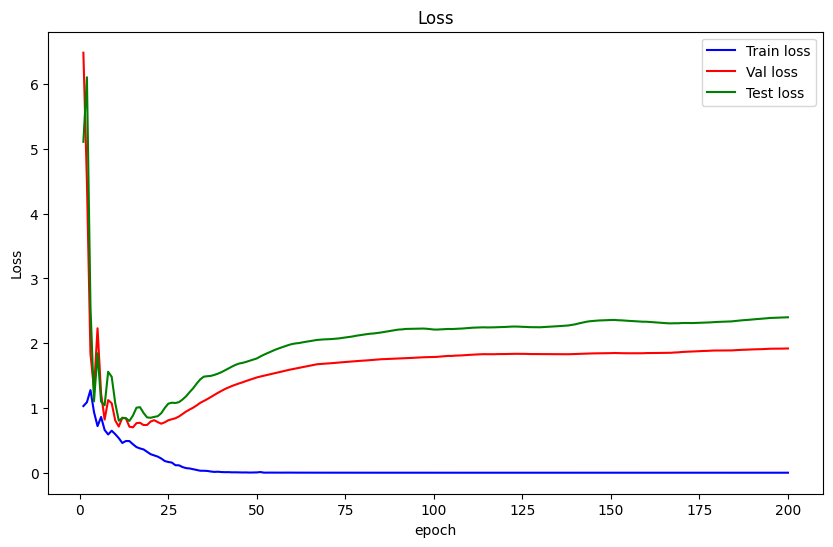

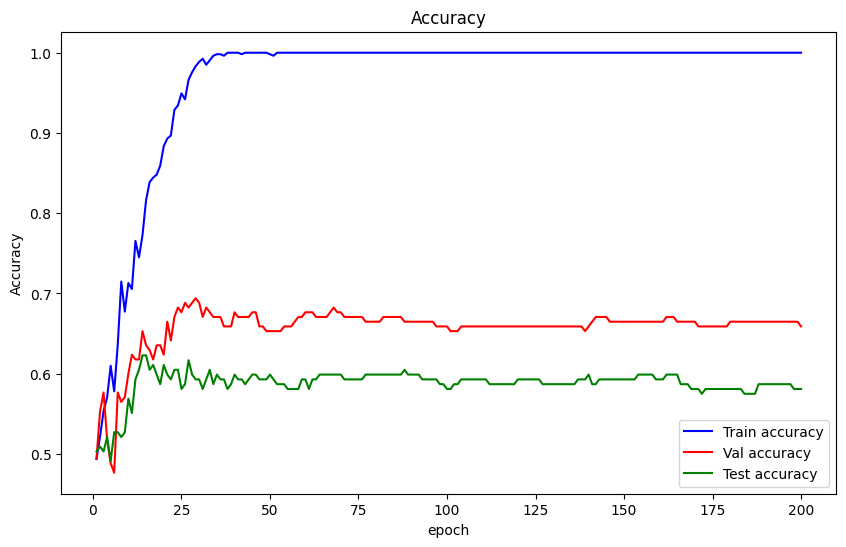



In fold  4
The best validaiton accuracy is:  0.6941176470588235
Happened at epoch:  29
The corresponding test accuracy 0.592814371257485
The corresponding test AUC is:  0.6294202898550725




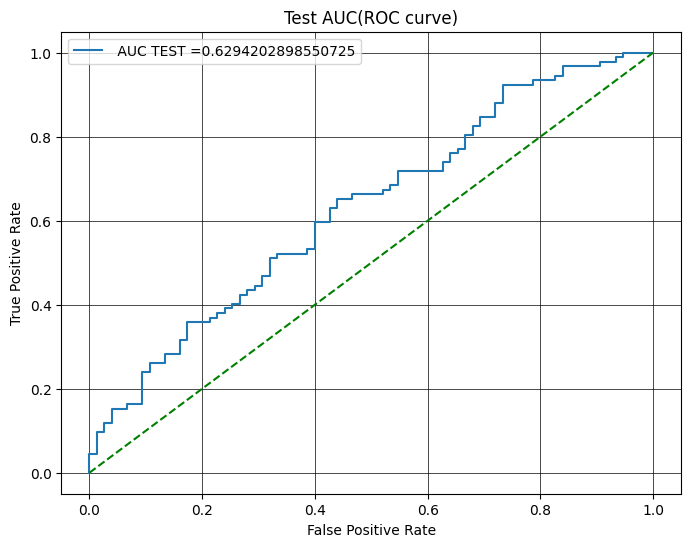

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 1.24623024	 train accuracy : 0.51055662	 val accuracy : 0.54491018	 test accuracy : 0.53296703	
Train Epoch: 2: train loss : 0.96145445	 train accuracy : 0.50671785	 val accuracy : 0.49700599	 test accuracy : 0.46703297	
Save models
Train Epoch: 3: train loss : 1.19971120	 train accuracy : 0.53742802	 val accuracy : 0.59880240	 test accuracy : 0.52197802	
Train Epoch: 4: train loss : 0.80750126	 train accuracy : 0.57581574	 val accuracy : 0.55089820	 test accuracy : 0.54945055	
Train Epoch: 5: train loss : 0.76528913	 train accuracy : 0.60652591	 val accuracy : 0.57485030	 test accuracy : 0.54395604	
Train Epoch: 6: train loss : 0.75734866	 train accuracy : 0.61036468	 val accuracy : 0.54491018	 test accuracy : 0.59340659	
Train Epoch: 7: train loss : 0.61785626	 train accuracy : 0.67562380	 val accuracy : 0.53293413	 test accuracy : 0.58241758	
Train Epoch: 8: train loss : 0.60882372	 train accuracy : 0.69097889	 va

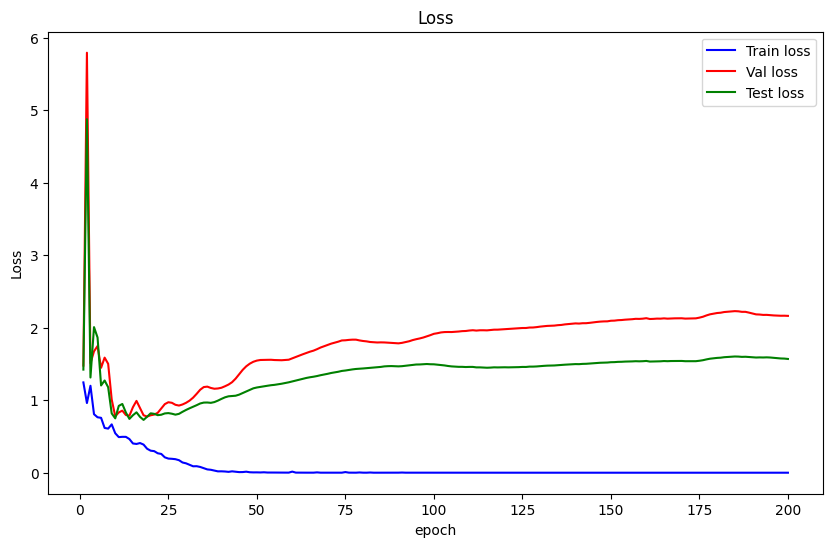

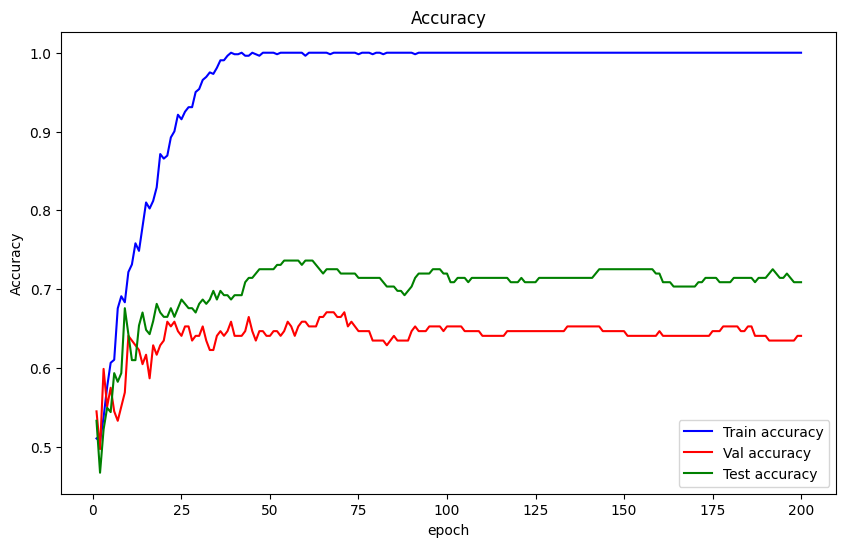



In fold  5
The best validaiton accuracy is:  0.6706586826347305
Happened at epoch:  71
The corresponding test accuracy 0.7197802197802198
The corresponding test AUC is:  0.7564195736434108




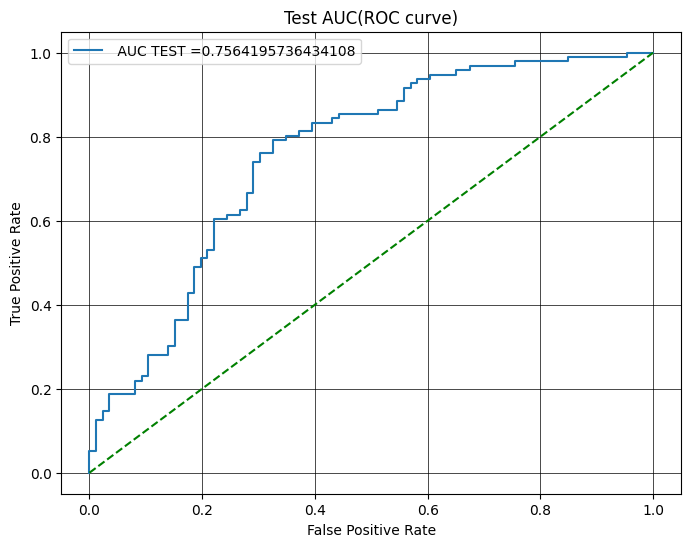

Finish 5-fold training
The best validation accuracy is  0.696551724137931
The corresponding test accuracy is  0.6540229885057471
The corresponding test AUC is:  0.6928204419742723


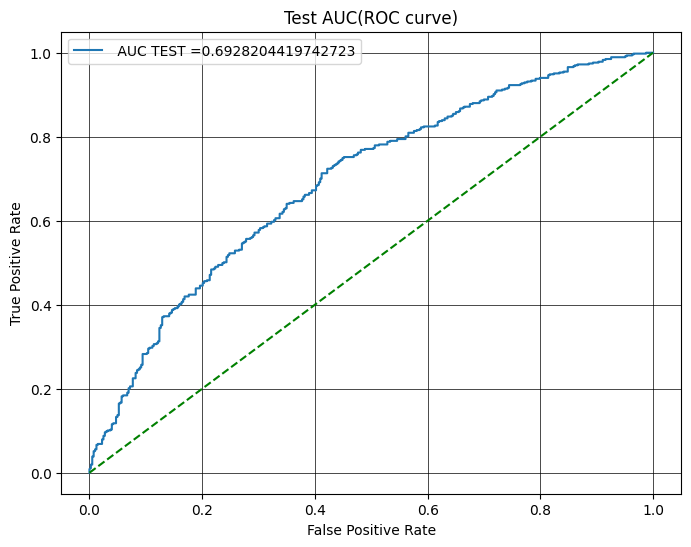

Loading trained models for evaluation...
  + Number of params: 228482
Fold 1 data shape: torch.Size([870, 6000])
Fold 2 data shape: torch.Size([870, 6000])
Fold 3 data shape: torch.Size([870, 6000])
Fold 4 data shape: torch.Size([870, 6000])
Fold 5 data shape: torch.Size([870, 6000])
Final test accuracy: 0.6540229885057471
Labels: [1 0 0 1 0 0 0 0 1 1]
Predictions: [1 0 0 1 0 1 1 0 1 1]


In [17]:
for fold in range(1, k_fold+1):
    model = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
    print('  + Number of params: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))
    model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
    if args.cuda:
        model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr = args.lr)

    best_validation_accuracy = 0
    Train_accuracy_list =[]
    Train_loss_list = []
    Val_accuracy_list =[]
    Val_loss_list = []
    Test_accuracy_list =[]
    Test_loss_list = []

    for epoch in range(1, args.nEpochs + 1):
        model, train_target, train_out, train_loss, val_target, val_out, val_loss, test_target, test_out, test_prob, test_loss = train(args, model, data[str(fold)], dist_train[str(fold)], dist_validation[str(fold)], dist_test[str(fold)], optimizer)

        train_accuracy = metrics.accuracy_score(train_target, train_out)
        val_accuracy = metrics.accuracy_score(val_target, val_out)
        test_accuracy = metrics.accuracy_score(test_target, test_out)
        Train_accuracy_list.append(train_accuracy)
        Val_accuracy_list.append(val_accuracy)
        Test_accuracy_list.append(test_accuracy)
        Train_loss_list.append(train_loss)
        Val_loss_list.append(val_loss)
        Test_loss_list.append(test_loss)

        if val_accuracy >= best_validation_accuracy:
            best_epoch = epoch
            best_validation_accuracy = val_accuracy
            corresponding_val_out = val_out
            corresponding_test_accuracy = test_accuracy
            corresponding_test_out = test_out
            corresponding_test_prob = test_prob

            print('Save models')
            save_model(model, save_path, 'EV_GCN_'+str(fold))

        print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
            train_loss, train_accuracy, val_accuracy, test_accuracy))

    if fold == 1:
        all_fold_val_label = val_target
        all_fold_val_out = corresponding_val_out
        all_fold_test_label = test_target
        all_fold_test_out = corresponding_test_out
        all_fold_test_prob = corresponding_test_prob
    else:
        all_fold_val_label = np.concatenate((all_fold_val_label, val_target),axis = 0)
        all_fold_val_out = np.concatenate((all_fold_val_out, corresponding_val_out),axis = 0)
        all_fold_test_label = np.concatenate((all_fold_test_label, test_target),axis = 0)
        all_fold_test_out = np.concatenate((all_fold_test_out, corresponding_test_out),axis = 0)
        all_fold_test_prob = np.concatenate((all_fold_test_prob, corresponding_test_prob),axis = 0)

    # Plot training curves
    x_axis = list(range(1, len(Train_accuracy_list)+1))
    plt.figure(figsize=(10,6))
    plt.plot(x_axis, Train_loss_list, c='b',label='Train loss')
    plt.plot(x_axis, Val_loss_list, c='r',label='Val loss')
    plt.plot(x_axis, Test_loss_list, c='g',label='Test loss')
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
    plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
    plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    test_fpr, test_tpr, te_thresholds = roc_curve(test_target, corresponding_test_prob[:,1],pos_label=1)
    test_auc = auc(test_fpr, test_tpr)
    print('\n')
    print('In fold ',str(fold))
    print('The best validaiton accuracy is: ',best_validation_accuracy)
    print('Happened at epoch: ',best_epoch)
    print('The corresponding test accuracy', corresponding_test_accuracy)
    print('The corresponding test AUC is: ',test_auc)
    print('\n')

    plt.figure(figsize=(8,6))
    plt.grid()
    plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(test_auc))
    plt.plot([0,1],[0,1],'g--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test AUC(ROC curve)")
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.show()

print('Finish 5-fold training')

val_accuracy = metrics.accuracy_score(all_fold_val_label, all_fold_val_out)
test_accuracy = metrics.accuracy_score(all_fold_test_label, all_fold_test_out)
test_fpr, test_tpr, te_thresholds = roc_curve(all_fold_test_label, all_fold_test_prob[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The best validation accuracy is ',val_accuracy)
print('The corresponding test accuracy is ',test_accuracy)
print('The corresponding test AUC is: ',test_auc)

plt.figure(figsize=(8,6))
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(test_auc))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

print("Loading trained models for evaluation...")

# Load trained models
model_1 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_2 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_3 = EV_GCN(args.input_dimension, args.num_classes,args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_4 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_5 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])

gpu_ids = range(args.ngpu)
model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model_1.parameters()])))

if args.cuda:
    model_1 = model_1.cuda()
    model_2 = model_2.cuda()
    model_3 = model_3.cuda()
    model_4 = model_4.cuda()
    model_5 = model_5.cuda()

# Load saved models
model_1 = load_model(model_1, save_path, 'EV_GCN_' + str(1))
model_2 = load_model(model_2, save_path, 'EV_GCN_' + str(2))
model_3 = load_model(model_3, save_path, 'EV_GCN_' + str(3))
model_4 = load_model(model_4, save_path, 'EV_GCN_' + str(4))
model_5 = load_model(model_5, save_path, 'EV_GCN_' + str(5))

# Evaluate models
for fold in range(1, k_fold+1):
    if fold == 1:
        model = model_1.eval()
    elif fold == 2:
        model = model_2.eval()
    elif fold == 3:
        model = model_3.eval()
    elif fold == 4:
        model = model_4.eval()
    elif fold == 5:
        model = model_5.eval()

    fold_test_index = dist_test[str(fold)]

    model.eval()

    data_test = torch.from_numpy(data[str(fold)][0])
    data_test = Variable(data_test, requires_grad=False)
    data_test = data_test.float()

    target = torch.from_numpy(data[str(fold)][1])
    target = target.float().long()

    edge_index = torch.from_numpy(data[str(fold)][2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(data[str(fold)][3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data_test, target, edge_index, edgenet_input = data_test.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data_test, edge_index, edgenet_input)
    print(f'Fold {fold} data shape:', data_test.shape)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    if fold == 1:
        EV_GCN_labels_concat = target
        EV_GCN_results_concat = out
        EV_GCN_results_prob_concat = out_prob
    else:
        EV_GCN_labels_concat = np.concatenate((EV_GCN_labels_concat, target),axis = 0)
        EV_GCN_results_concat = np.concatenate((EV_GCN_results_concat, out),axis = 0)
        EV_GCN_results_prob_concat = np.concatenate((EV_GCN_results_prob_concat, out_prob),axis = 0)

# Fix label ordering
EV_GCN_labels_concat = 1 - EV_GCN_labels_concat
EV_GCN_results_concat = 1 - EV_GCN_results_concat
EV_GCN_results_prob_concat_change = np.zeros_like(EV_GCN_results_prob_concat)
EV_GCN_results_prob_concat_change[:,0] = EV_GCN_results_prob_concat[:,1]
EV_GCN_results_prob_concat_change[:,1] = EV_GCN_results_prob_concat[:,0]

test_accuracy = metrics.accuracy_score(EV_GCN_labels_concat, EV_GCN_results_concat)
print('Final test accuracy:', test_accuracy)
print('Labels:', EV_GCN_labels_concat[:10])  # Show first 10 for verification
print('Predictions:', EV_GCN_results_concat[:10])

torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


Max voting

Starting ensemble training with max voting...
Ensemble  1
Fitting estimator with 6670 features.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting estimator with 6170 features.
Fitting estimator with 6070 features.
Fitting estimator with 5970 features.
Fitting estimator with 5870 features.
Fitting estimator with 5770 features.
Fitting estimator with 5670 features.
Fitting estimator with 5570 features.
Fitting estimator with 5470 features.
Fitting estimator with 5370 features.
Fitting estimator with 5270 features.
Fitting estimator with 5170 features.
Fitting estimator with 5070 features.
Fitting estimator with 6435 features.
Fitting estimator with 6335 features.
Fitting estimator with 6235 features.
Fitting estimator with 6135 features.
Fitting estimator with 6035 features.
Fitting estimator with 6670 features.
Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting esti

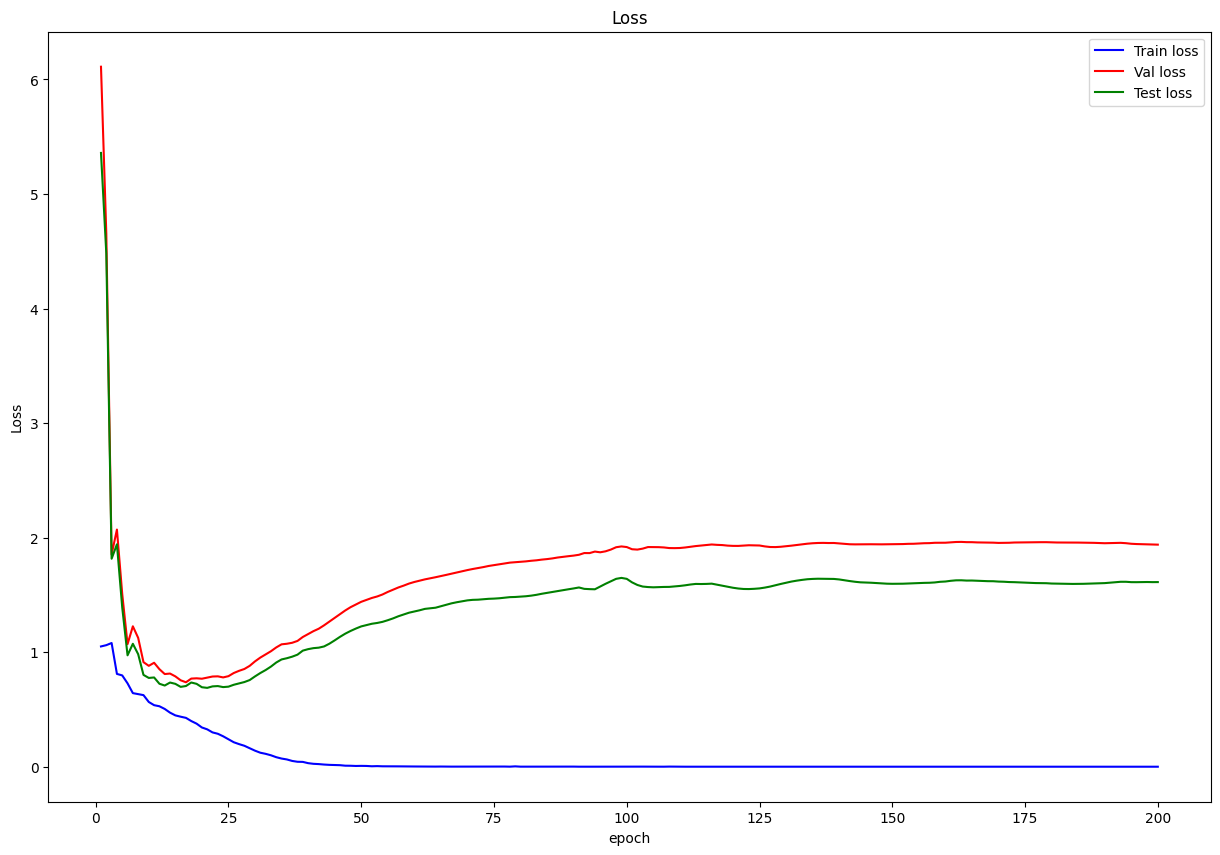

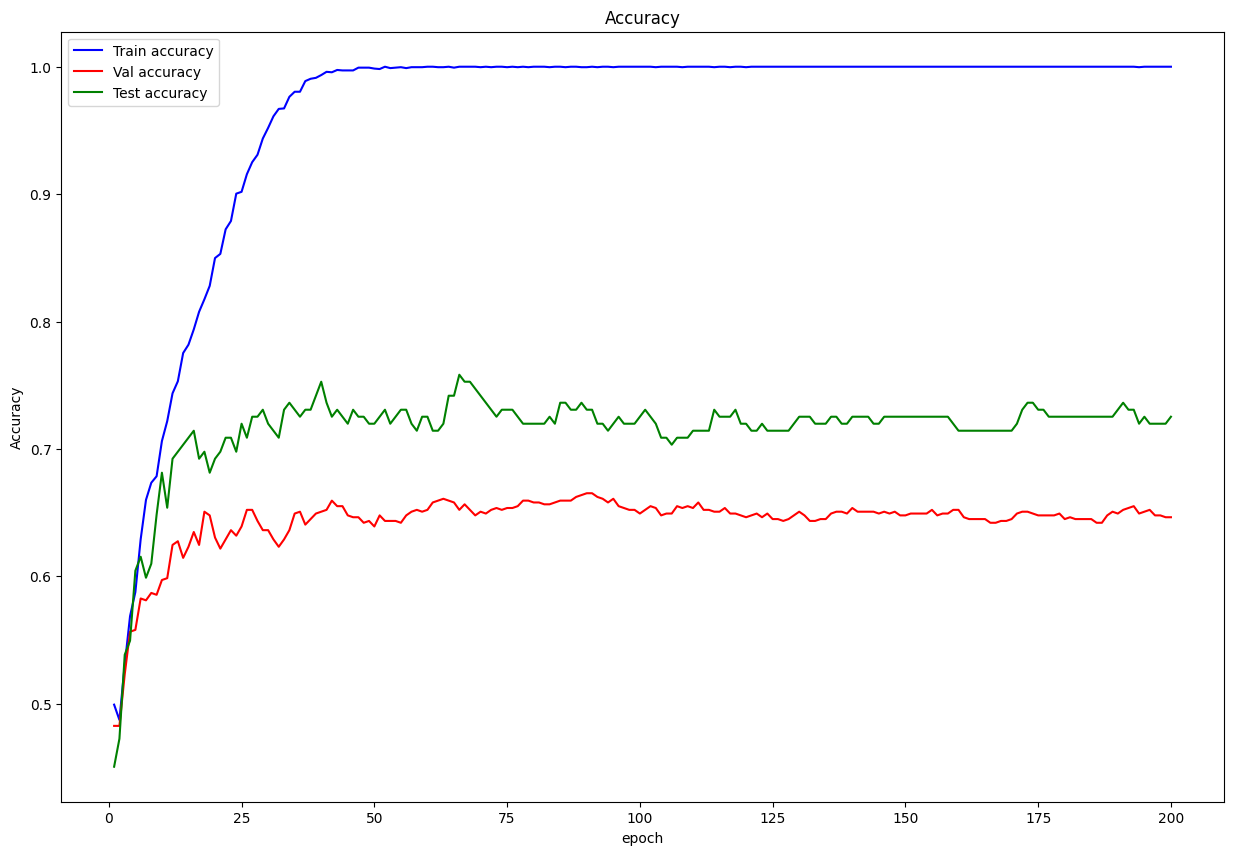



In ensemble  1
The best validation accuracy is:  0.6652173913043479
Happened at epoch:  91
The corresponding test accuracy 0.7307692307692307
The corresponding test AUC is:  0.7921511627906976




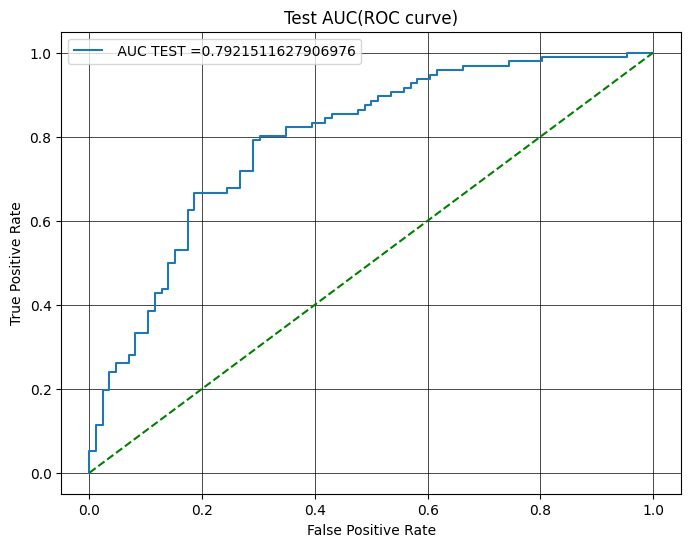



Ensemble  2
Fitting estimator with 6670 features.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting estimator with 6170 features.
Fitting estimator with 6070 features.
Fitting estimator with 5970 features.
Fitting estimator with 5870 features.
Fitting estimator with 5770 features.
Fitting estimator with 5670 features.
Fitting estimator with 5570 features.
Fitting estimator with 5470 features.
Fitting estimator with 5370 features.
Fitting estimator with 5270 features.
Fitting estimator with 5170 features.
Fitting estimator with 5070 features.
Fitting estimator with 6435 features.
Fitting estimator with 6335 features.
Fitting estimator with 6235 features.
Fitting estimator with 6135 features.
Fitting estimator with 6035 features.
Fitting estimator with 6670 features.
Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting esti

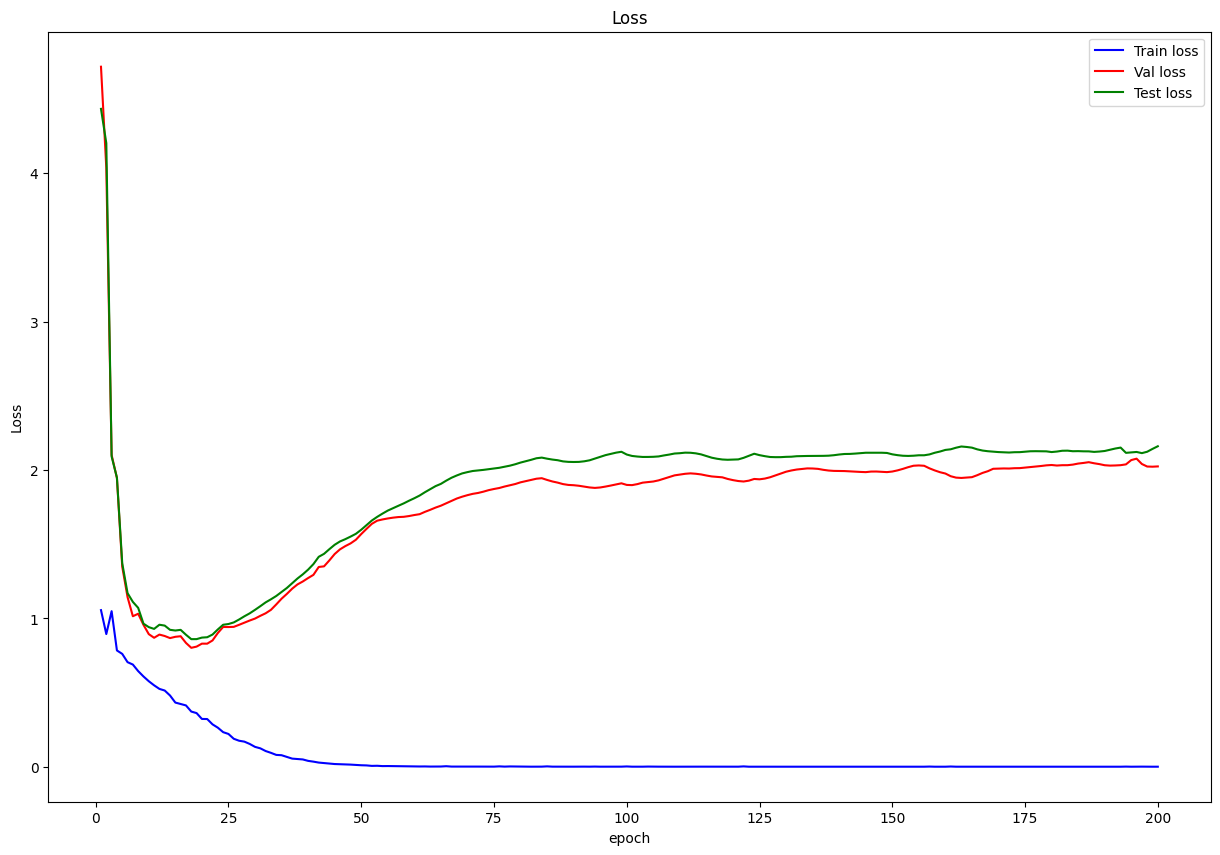

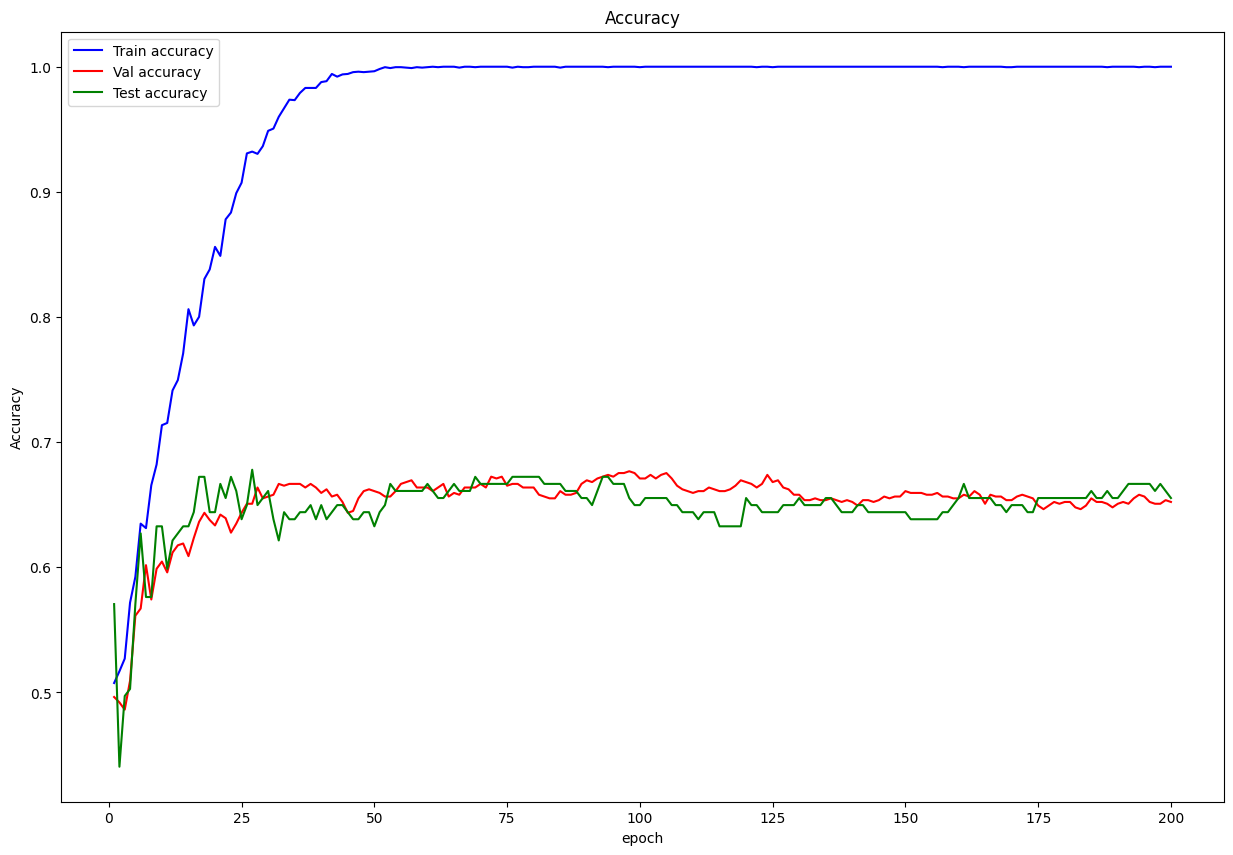



In ensemble  2
The best validation accuracy is:  0.6767676767676768
Happened at epoch:  98
The corresponding test accuracy 0.655367231638418
The corresponding test AUC is:  0.701918158567775




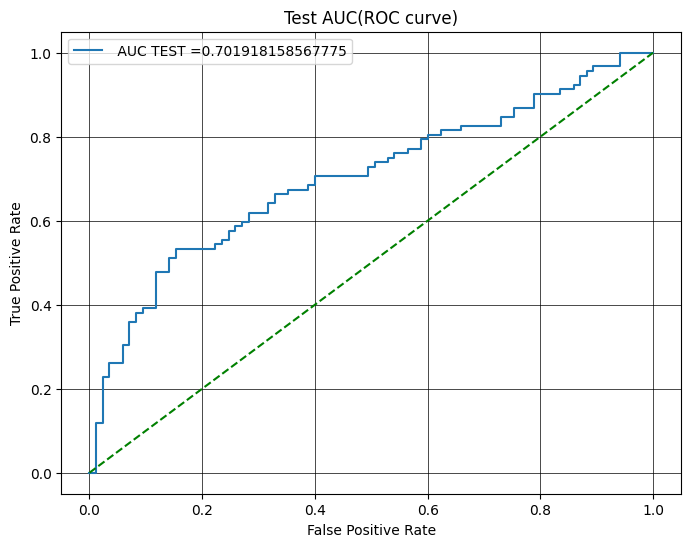



Ensemble  3
Fitting estimator with 6670 features.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting estimator with 6170 features.
Fitting estimator with 6070 features.
Fitting estimator with 5970 features.
Fitting estimator with 5870 features.
Fitting estimator with 5770 features.
Fitting estimator with 5670 features.
Fitting estimator with 5570 features.
Fitting estimator with 5470 features.
Fitting estimator with 5370 features.
Fitting estimator with 5270 features.
Fitting estimator with 5170 features.
Fitting estimator with 5070 features.
Fitting estimator with 6435 features.
Fitting estimator with 6335 features.
Fitting estimator with 6235 features.
Fitting estimator with 6135 features.
Fitting estimator with 6035 features.
Fitting estimator with 6670 features.
Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting esti

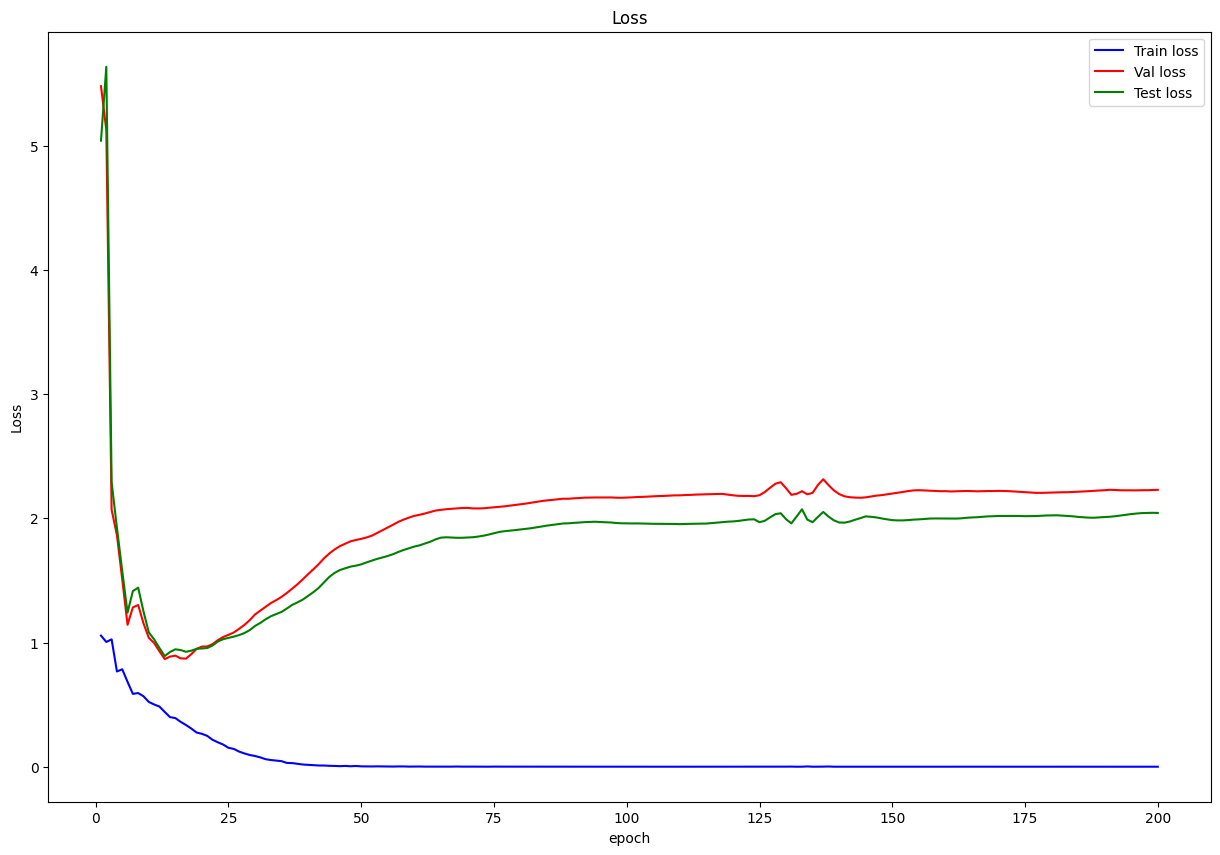

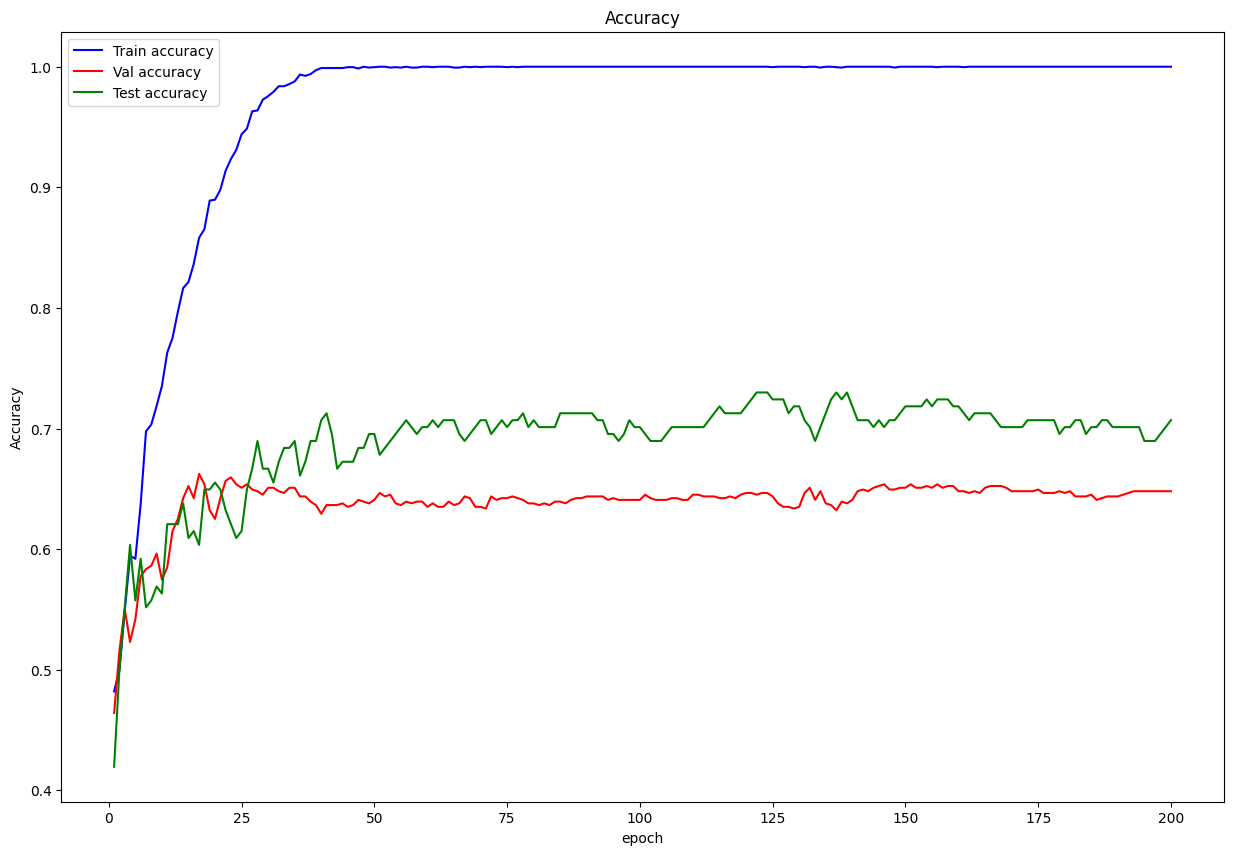



In ensemble  3
The best validation accuracy is:  0.6623563218390804
Happened at epoch:  17
The corresponding test accuracy 0.603448275862069
The corresponding test AUC is:  0.6896322846143635




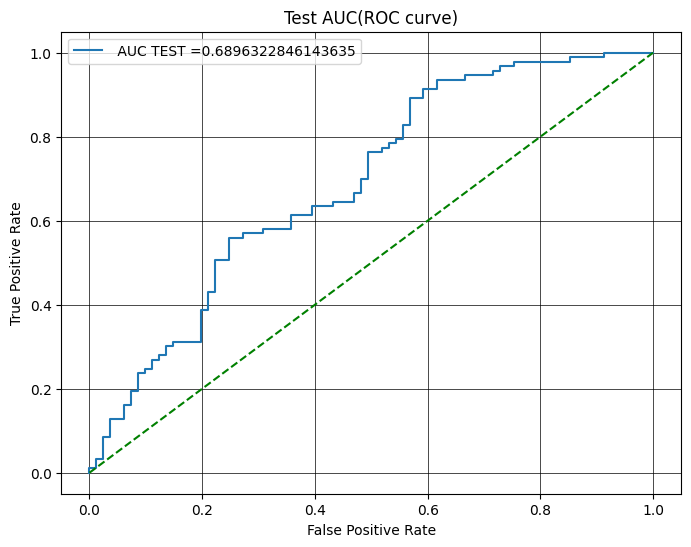



Ensemble  4
Fitting estimator with 6670 features.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting estimator with 6170 features.
Fitting estimator with 6070 features.
Fitting estimator with 5970 features.
Fitting estimator with 5870 features.
Fitting estimator with 5770 features.
Fitting estimator with 5670 features.
Fitting estimator with 5570 features.
Fitting estimator with 5470 features.
Fitting estimator with 5370 features.
Fitting estimator with 5270 features.
Fitting estimator with 5170 features.
Fitting estimator with 5070 features.
Fitting estimator with 6435 features.
Fitting estimator with 6335 features.
Fitting estimator with 6235 features.
Fitting estimator with 6135 features.
Fitting estimator with 6035 features.
Fitting estimator with 6670 features.
Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting esti

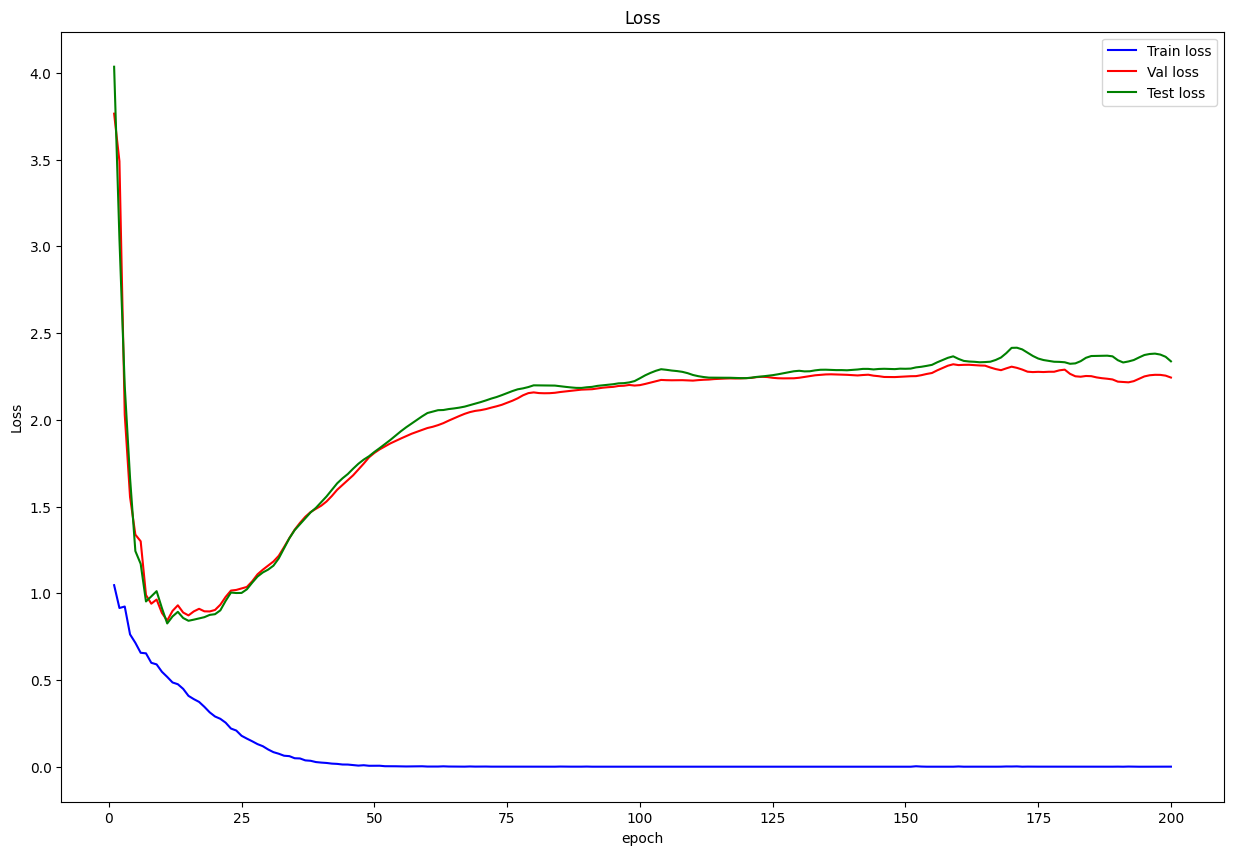

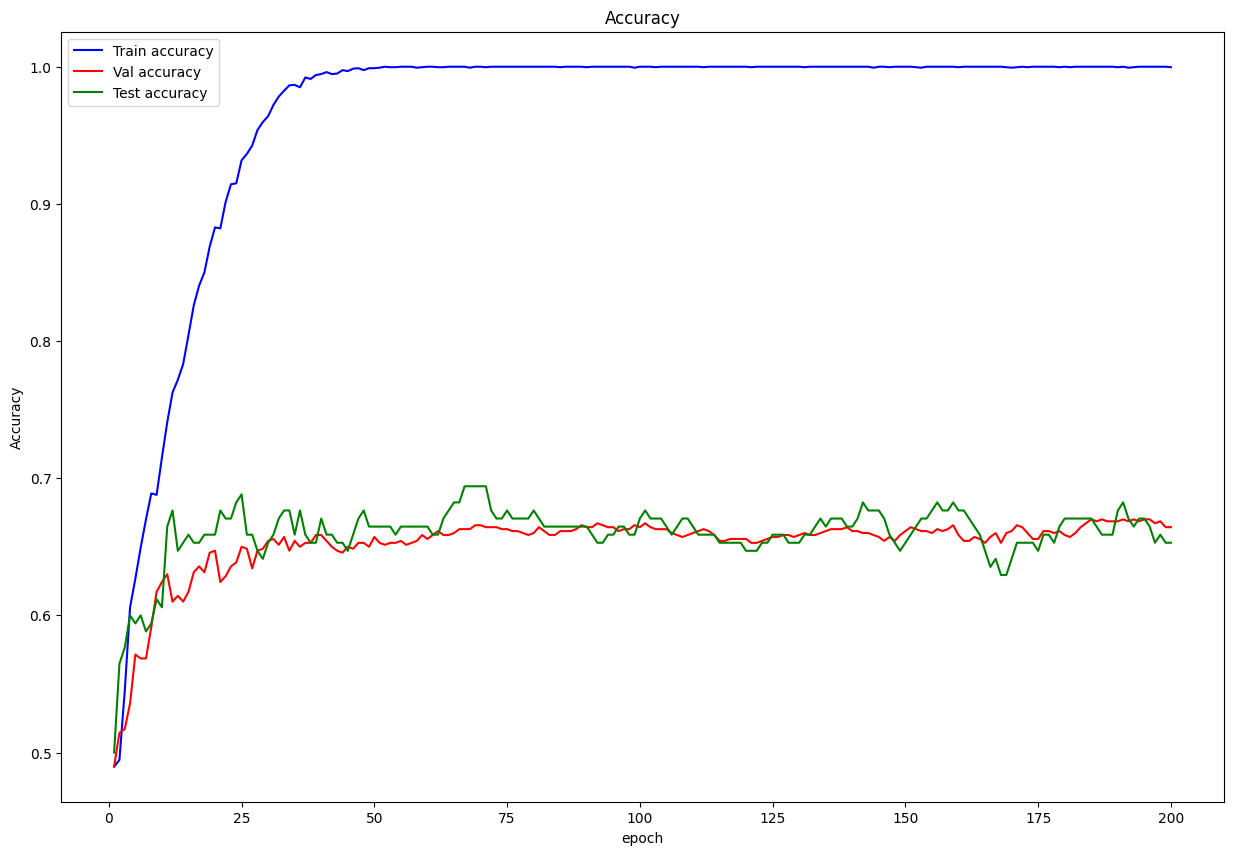



In ensemble  4
The best validation accuracy is:  0.67
Happened at epoch:  196
The corresponding test accuracy 0.6647058823529411
The corresponding test AUC is:  0.7084266517357223




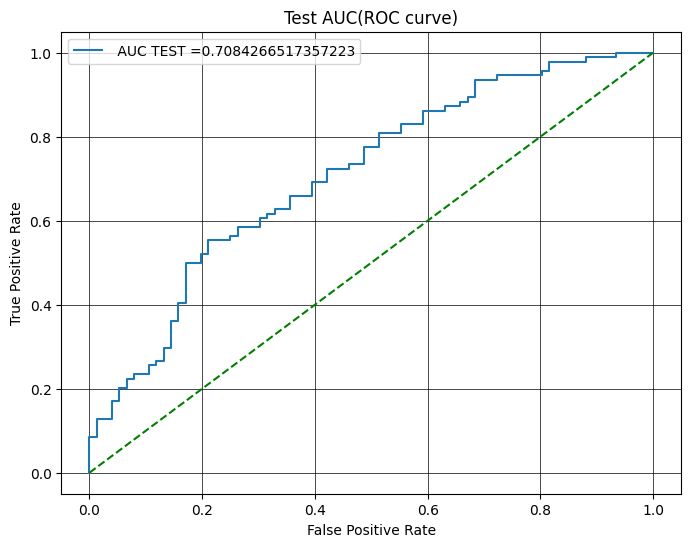



Ensemble  5
Fitting estimator with 6670 features.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting estimator with 6170 features.
Fitting estimator with 6070 features.
Fitting estimator with 5970 features.
Fitting estimator with 5870 features.
Fitting estimator with 5770 features.
Fitting estimator with 5670 features.
Fitting estimator with 5570 features.
Fitting estimator with 5470 features.
Fitting estimator with 5370 features.
Fitting estimator with 5270 features.
Fitting estimator with 5170 features.
Fitting estimator with 5070 features.
Fitting estimator with 6435 features.
Fitting estimator with 6335 features.
Fitting estimator with 6235 features.
Fitting estimator with 6135 features.
Fitting estimator with 6035 features.
Fitting estimator with 6670 features.
Fitting estimator with 6570 features.
Fitting estimator with 6470 features.
Fitting estimator with 6370 features.
Fitting estimator with 6270 features.
Fitting esti

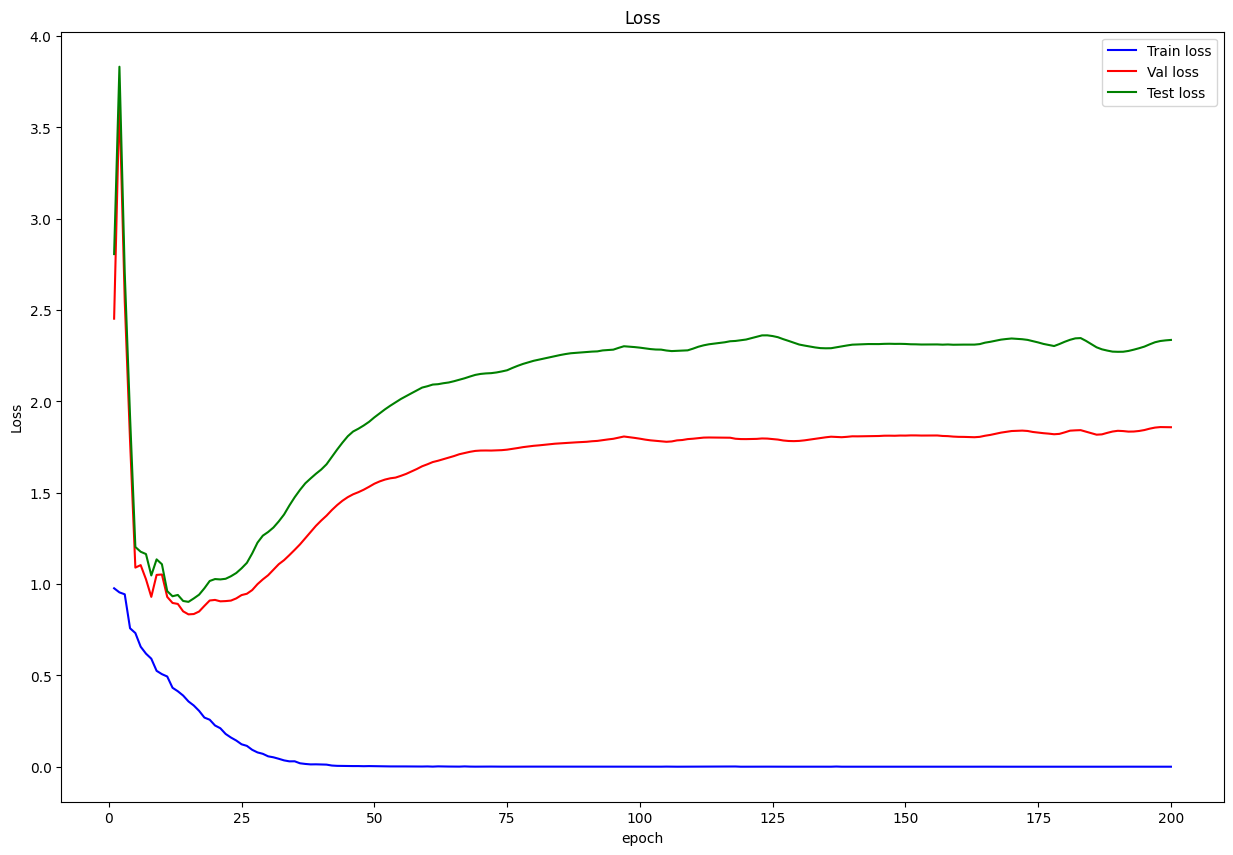

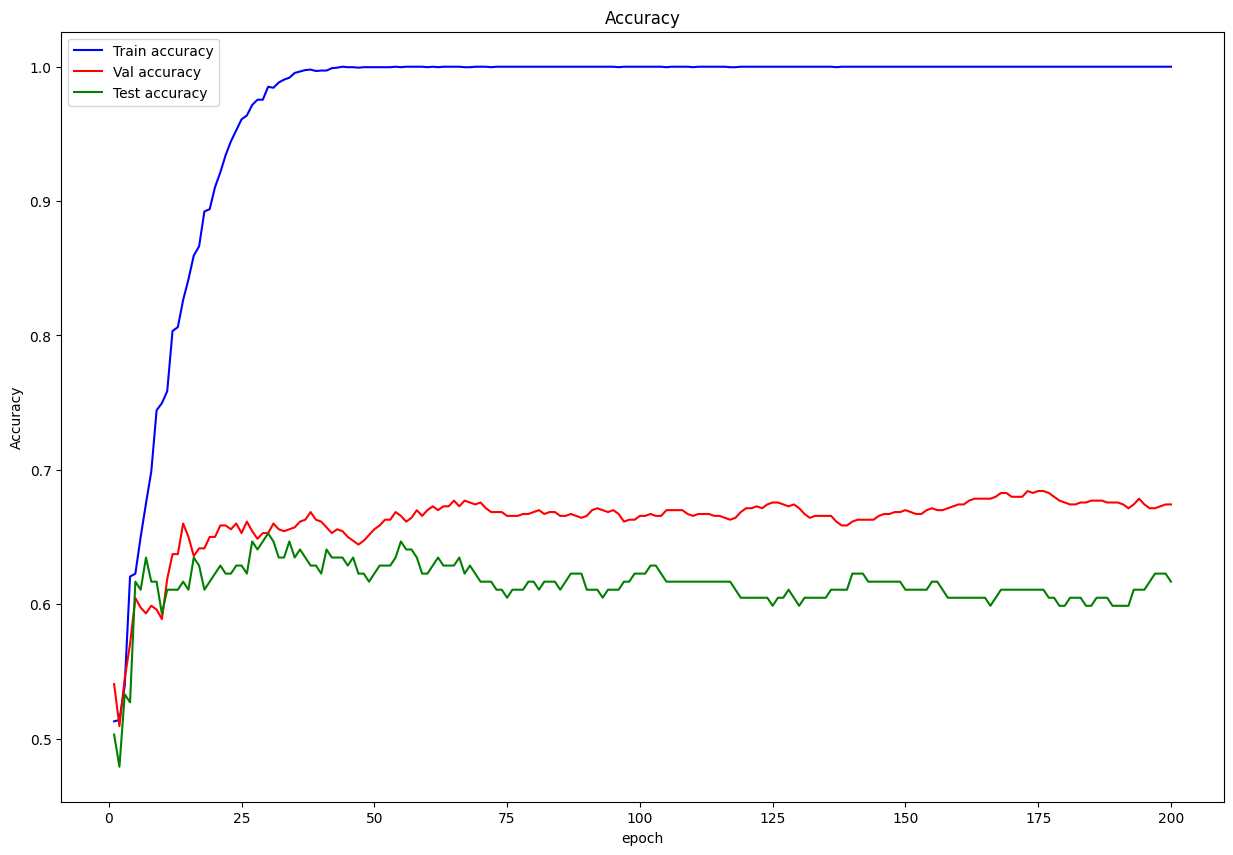



In ensemble  5
The best validation accuracy is:  0.6842105263157895
Happened at epoch:  176
The corresponding test accuracy 0.6107784431137725
The corresponding test AUC is:  0.6707246376811594




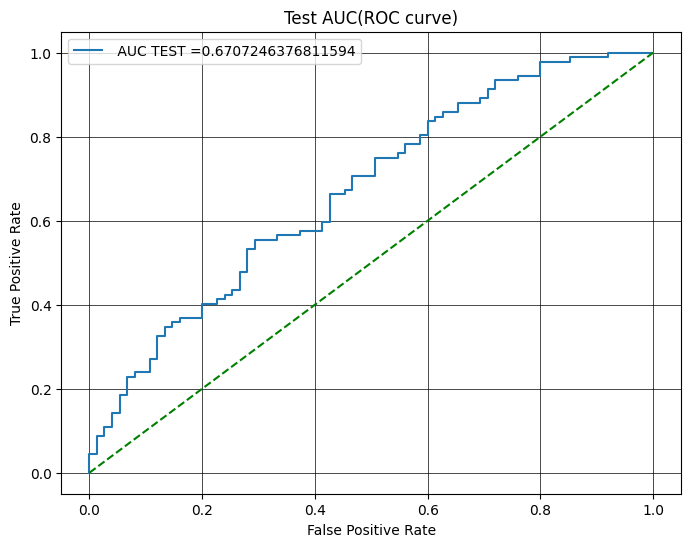



The Max voting test accuracy is:  0.6540229885057471
The test AUC is:  0.7141619863868949






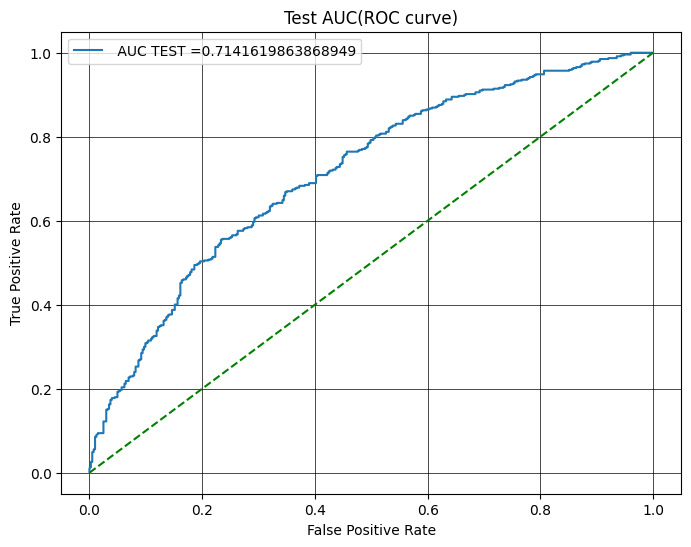

Analysis completed successfully!


In [18]:
print("Starting ensemble training with max voting...")

dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
    print('Ensemble ',ensemble_fold+1)
    save_ensemble_models_path = save_path + 'Max_voting/EV_GCN/'

    # Initialize distributions for this ensemble
    dist_train = {}
    dist_validation = {}
    dist_test = {}
    for i in range(k_fold):
        dist_train[str(i + 1)] = []
        dist_validation[str(i + 1)] = []
        dist_test[str(i + 1)] = []

    test_name = {}
    for i in range(len(unique_sites)):
        test_name[unique_sites[i]] = []

    # Create test sets for ensemble
    for each_site in unique_sites:
        index_site = get_index(sites, each_site)
        label_site = np.zeros((len(index_site)))
        for i in range(len(index_site)):
            index = index_site[i]
            label_site[i] = int(labels[int(index)])
        test_name_list = test_name[each_site]

        # StratifiedKFold
        sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site, label_site):
            if group == ensemble_fold:
                for j in validation:
                    name = index_site[j]
                    dist_test['1'].append(name)
                    dist_test['2'].append(name)
                    dist_test['3'].append(name)
                    dist_test['4'].append(name)
                    dist_test['5'].append(name)
                    test_name_list.append(name)
            group = group + 1
        test_name[each_site] = test_name_list

    # Create training and validation sets
    for each_site in unique_sites:
        if ensemble_fold == 0:
            index_site = get_index(sites, each_site)
            label_site = np.zeros((len(index_site)))
            for i in range(len(index_site)):
                index = index_site[i]
                label_site[i] = int(labels[int(index)])
            test_name_list = test_name[each_site]
            index_site_new = []
            label_new = []
            for x in range(len(index_site)):
                sample_name = index_site[x]
                if sample_name not in test_name_list:
                    index_site_new.append(sample_name)
                    label_new.append(label_site[x])

            label_new = np.array(label_new)

            if each_site == 'CMU':  # Special handling for CMU site
                group_autism_val = []
                group_autism_train = []
                group_TD_val = []
                group_TD_train = []
                autism_validation_number = len(label_new[label_new ==1])/4
                TD_validation_number = len(label_new[label_new ==0]) / 4

                for j in range(len(label_new)):
                    if label_new[j] == 1:
                        if len(group_autism_val) < autism_validation_number:
                            group_autism_val.append(index_site_new[j])
                        else:
                            group_autism_train.append(index_site_new[j])
                    else:
                        if len(group_TD_val) < TD_validation_number:
                            group_TD_val.append(index_site_new[j])
                        else:
                            group_TD_train.append(index_site_new[j])

                for k in range(k_fold):
                    dist_train[str(k + 1)].extend(group_autism_train)
                    dist_train[str(k + 1)].extend(group_TD_train)
                    dist_validation[str(k + 1)].extend(group_autism_val)
                    dist_validation[str(k + 1)].extend(group_TD_val)
            else:
                # Normal stratified k-fold for other sites
                if len(index_site_new) > 0:
                    sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
                    group = 0
                    for train, validation in sfolder.split(index_site_new, label_new):
                        for i in train:
                            dist_train[str(group + 1)].append(index_site_new[i])
                        for j in validation:
                            dist_validation[str(group + 1)].append(index_site_new[j])
                        group = group + 1

        else:  # ensemble_fold != 0
            index_site = get_index(sites, each_site)
            label_site = np.zeros((len(index_site)))
            for i in range(len(index_site)):
                index = index_site[i]
                label_site[i] = int(labels[int(index)])
            test_name_list = test_name[each_site]
            index_site_new = []
            label_new = []
            for x in range(len(index_site)):
                sample_name = index_site[x]
                if sample_name not in test_name_list:
                    index_site_new.append(sample_name)
                    label_new.append(label_site[x])

            label_new = np.array(label_new)

            if len(index_site_new) > 0:
                sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
                group = 0
                for train, validation in sfolder.split(index_site_new, label_new):
                    for i in train:
                        dist_train[str(group + 1)].append(index_site_new[i])
                    for j in validation:
                        dist_validation[str(group + 1)].append(index_site_new[j])
                    group = group + 1

    # Prepare data for ensemble training
    data = {}
    for fold in range(1, k_fold+1):
        data[str(fold)] = []
        selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
        selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

        new_fMRI_data = selector_fMRI.transform(fMRI_images)
        new_sMRI_data = selector_sMRI.transform(sMRI_features)

        # Combine features
        sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
        selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
        fold_data = selector_combine.transform(sMRI_fMRI_combine)

        n = fold_data.shape[0]
        num_edge = n * n
        edge_index = np.zeros([2, num_edge], dtype=np.int64)
        edgenet_input = np.zeros([num_edge, 2*phonetic_data.shape[1]], dtype=np.float32)
        aff_score = np.zeros(num_edge, dtype=np.float32)

        aff_adj = get_static_affinity_adj(fold_data, pd_dict)

        # Create complete graph
        flatten_ind = 0
        for i in range(n):
            for j in range(n):
                edge_index[:, flatten_ind] = [i, j]
                edgenet_input[flatten_ind] = np.concatenate((phonetic_data[i], phonetic_data[j]))
                aff_score[flatten_ind] = aff_adj[i][j]
                flatten_ind += 1

        keep_ind = np.where(aff_score > 1.1)[0]
        edge_index = edge_index[:, keep_ind]
        edgenet_input = edgenet_input[keep_ind]
        edgenet_input = (edgenet_input- edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)

        data[str(fold)].append(fold_data)
        data[str(fold)].append(EV_GCN_labels)
        data[str(fold)].append(edge_index)
        data[str(fold)].append(edgenet_input)

    # Train ensemble models
    model_1 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
    model_2 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
    model_3 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
    model_4 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
    model_5 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])

    gpu_ids = range(args.ngpu)
    model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
    model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
    model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
    model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
    model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)
    train = train_EV_GCN

    print('  + Number of params: {}'.format(
        sum([p.data.nelement() for p in model_1.parameters()])))

    if args.cuda:
        model_1 = model_1.cuda()
        model_2 = model_2.cuda()
        model_3 = model_3.cuda()
        model_4 = model_4.cuda()
        model_5 = model_5.cuda()

    optimizer_1 = optim.Adam(model_1.parameters(), lr = args.lr, weight_decay=args.wd)
    optimizer_2 = optim.Adam(model_2.parameters(), lr = args.lr, weight_decay=args.wd)
    optimizer_3 = optim.Adam(model_3.parameters(), lr = args.lr, weight_decay=args.wd)
    optimizer_4 = optim.Adam(model_4.parameters(), lr = args.lr, weight_decay=args.wd)
    optimizer_5 = optim.Adam(model_5.parameters(), lr = args.lr, weight_decay=args.wd)

    Train_accuracy_list =[]
    Train_loss_list = []
    Val_accuracy_list =[]
    Val_loss_list = []
    Test_accuracy_list =[]
    Test_loss_list = []
    best_validation_accuracy = 0

    for epoch in range(1, args.nEpochs + 1):
        model_1, train_target_1, train_out_1, train_loss_1, val_target_1, val_out_1, val_loss_1, test_target_1, test_out_1, test_prob_1, test_loss_1 = train(args, model_1, data['1'], dist_train['1'], dist_validation['1'], dist_test['1'], optimizer_1)
        model_2, train_target_2, train_out_2, train_loss_2, val_target_2, val_out_2, val_loss_2, test_target_2, test_out_2, test_prob_2, test_loss_2 = train(args, model_2, data['2'], dist_train['2'], dist_validation['2'], dist_test['2'], optimizer_2)
        model_3, train_target_3, train_out_3, train_loss_3, val_target_3, val_out_3, val_loss_3, test_target_3, test_out_3, test_prob_3, test_loss_3 = train(args, model_3, data['3'], dist_train['3'], dist_validation['3'], dist_test['3'], optimizer_3)
        model_4, train_target_4, train_out_4, train_loss_4, val_target_4, val_out_4, val_loss_4, test_target_4, test_out_4, test_prob_4, test_loss_4 = train(args, model_4, data['4'], dist_train['4'], dist_validation['4'], dist_test['4'], optimizer_4)
        model_5, train_target_5, train_out_5, train_loss_5, val_target_5, val_out_5, val_loss_5, test_target_5, test_out_5, test_prob_5, test_loss_5 = train(args, model_5, data['5'], dist_train['5'], dist_validation['5'], dist_test['5'], optimizer_5)

        train_target_all = np.concatenate((train_target_1, train_target_2, train_target_3, train_target_4, train_target_5),axis = 0)
        train_out_all = np.concatenate((train_out_1, train_out_2, train_out_3, train_out_4, train_out_5),axis = 0)
        train_loss = (train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4 + train_loss_5)/5
        val_target_all = np.concatenate((val_target_1, val_target_2, val_target_3, val_target_4, val_target_5),axis = 0)
        val_out_all = np.concatenate((val_out_1, val_out_2, val_out_3, val_out_4, val_out_5),axis = 0)
        val_loss = (val_loss_1 + val_loss_2 + val_loss_3 + val_loss_4 + val_loss_5)/5
        test_target_all = test_target_1  # All test targets should be the same
        test_out_all = test_out_1 + test_out_2 + test_out_3 + test_out_4 + test_out_5
        test_prob_all = (test_prob_1 + test_prob_2 + test_prob_3 + test_prob_4 + test_prob_5)/5
        test_loss = (test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4 + test_loss_5)/5

        test_results_binary = np.zeros_like(test_out_all)
        test_results_binary[test_out_all < 2.5] = 0
        test_results_binary[test_out_all >= 2.5] = 1

        train_accuracy = metrics.accuracy_score(train_target_all, train_out_all)
        val_accuracy = metrics.accuracy_score(val_target_all, val_out_all)
        test_accuracy = metrics.accuracy_score(test_target_all, test_results_binary)
        Train_accuracy_list.append(train_accuracy)
        Val_accuracy_list.append(val_accuracy)
        Test_accuracy_list.append(test_accuracy)
        Train_loss_list.append(train_loss)
        Val_loss_list.append(val_loss)
        Test_loss_list.append(test_loss)

        if val_accuracy >= best_validation_accuracy:
            best_epoch = epoch
            best_validation_accuracy = val_accuracy
            corresponding_test_accuracy = test_accuracy
            corresponding_test_prob = test_prob_all
            corresponding_test_labels = test_target_all
            corresponding_test_out = test_results_binary
            print('Save models')

            save_model(model_1, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_1')
            save_model(model_2, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_2')
            save_model(model_3, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_3')
            save_model(model_4, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_4')
            save_model(model_5, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_5')

        print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
            train_loss, train_accuracy, val_accuracy, test_accuracy))

    # Plot training curves
    x_axis = list(range(1, len(Train_accuracy_list)+1))
    plt.figure(figsize=(15,10))
    plt.plot(x_axis, Train_loss_list, c='b',label='Train loss')
    plt.plot(x_axis, Val_loss_list, c='r',label='Val loss')
    plt.plot(x_axis, Test_loss_list, c='g',label='Test loss')
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
    plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
    plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    test_fpr, test_tpr, te_thresholds = roc_curve(corresponding_test_labels, corresponding_test_prob[:,1],pos_label=1)
    test_auc = auc(test_fpr, test_tpr)
    print('\n')
    print('In ensemble ',ensemble_fold+1)
    print('The best validation accuracy is: ',best_validation_accuracy)
    print('Happened at epoch: ',best_epoch)
    print('The corresponding test accuracy', corresponding_test_accuracy)
    print('The corresponding test AUC is: ',test_auc)
    print('\n')

    plt.figure(figsize=(8,6))
    plt.grid()
    plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
    plt.plot([0,1],[0,1],'g--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test AUC(ROC curve)")
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.show()

    dist_ensemble_test_label[str(ensemble_fold+1)] = corresponding_test_labels
    dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_out
    dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_prob
    print('\n')

    torch.cuda.empty_cache()

# Final ensemble results
test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'], dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'], dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'], dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.figure(figsize=(8,6))
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

print("Analysis completed successfully!")

UNCERTAINTY ESTIMATION MODULE

Monte Carlo Dropout + Test-Time Augmentation

 UNCERTAINTY ESTIMATION MODULE
   Implementing Monte Carlo Dropout + Test-Time Augmentation
 Loading trained models for uncertainty estimation...

🎯 Running Uncertainty Estimation...

Fold 1 - Uncertainty Analysis
    Baseline prediction...
    Monte Carlo Dropout...
    Test-Time Augmentation...
    Combined Uncertainty...

Fold 2 - Uncertainty Analysis
    Baseline prediction...
    Monte Carlo Dropout...
    Test-Time Augmentation...
    Combined Uncertainty...

Fold 3 - Uncertainty Analysis
    Baseline prediction...
    Monte Carlo Dropout...
    Test-Time Augmentation...
    Combined Uncertainty...

Fold 4 - Uncertainty Analysis
    Baseline prediction...
    Monte Carlo Dropout...
    Test-Time Augmentation...
    Combined Uncertainty...

Fold 5 - Uncertainty Analysis
    Baseline prediction...
    Monte Carlo Dropout...
    Test-Time Augmentation...
    Combined Uncertainty...

Uncertainty estimation completed!

 UNCERTAINTY ANALYSIS & VISUALIZATION

Performance Comparison:
   

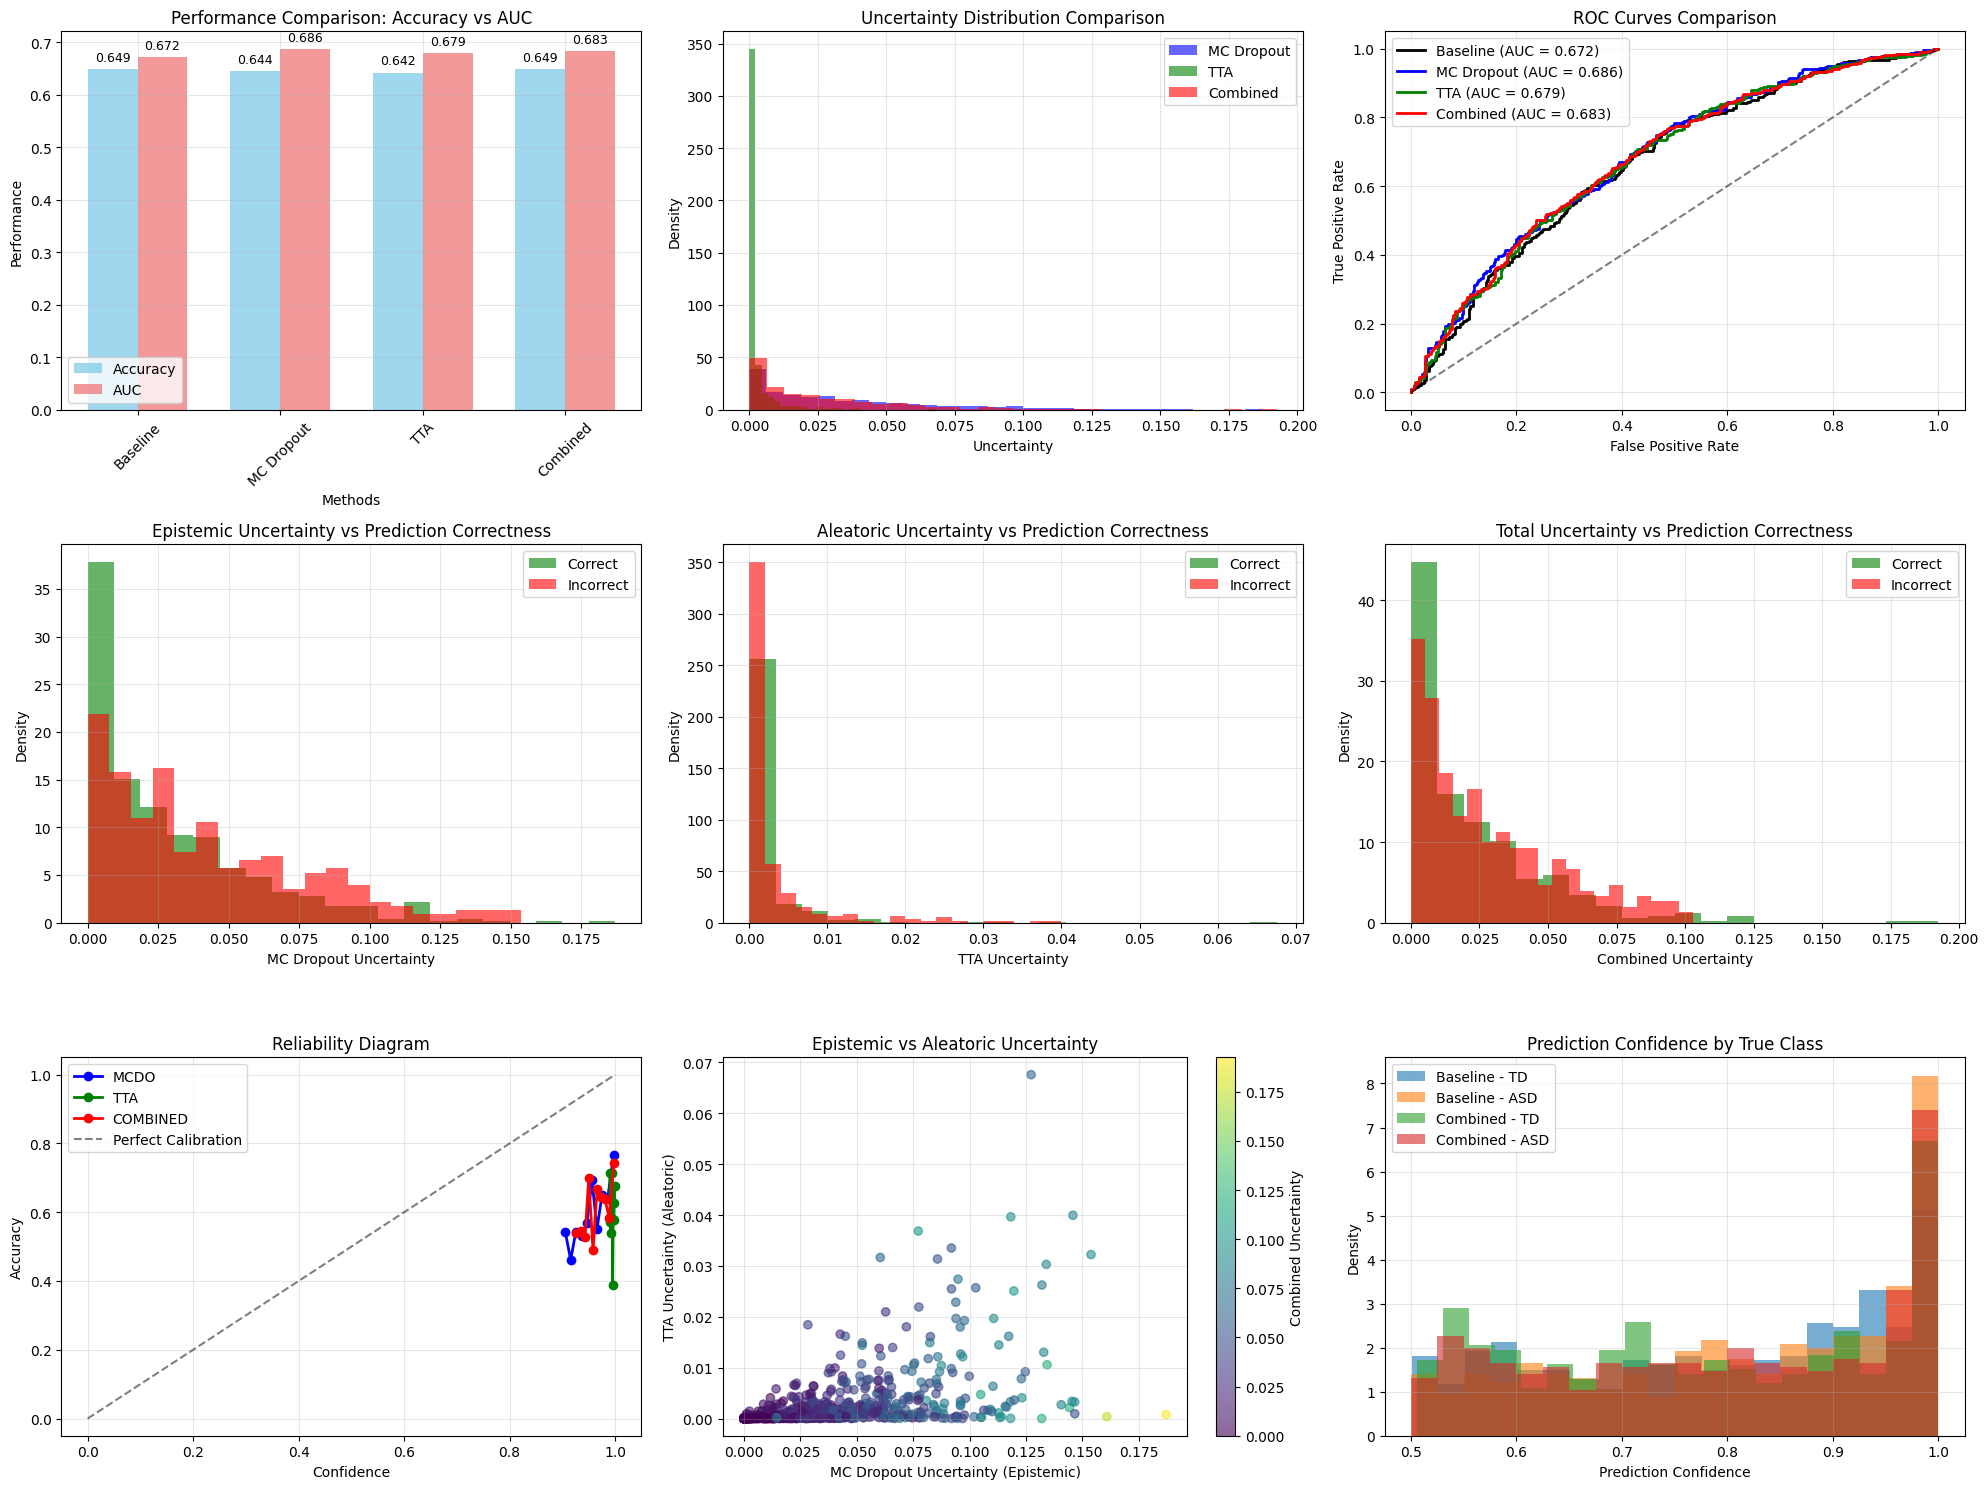


 UNCERTAINTY ESTIMATION SUMMARY:

 Performance Improvements:
   Accuracy: 0.6491 → 0.6491 (+0.00%)
   AUC:      0.6719 → 0.6832 (+1.13%)

 Uncertainty Characteristics:
   MC Dropout (Epistemic):  μ=0.0335, σ=0.0335
   TTA (Aleatoric):         μ=0.0023, σ=0.0055
   Combined (Total):        μ=0.0243, σ=0.0261

Clinical Decision Support:
   High uncertainty cases (top 20%): 167 patients
   Accuracy in high uncertainty cases: 0.5569
   Recommend expert review for these 167 cases


In [19]:
print(" UNCERTAINTY ESTIMATION MODULE")
print("   Implementing Monte Carlo Dropout + Test-Time Augmentation")

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

class UncertaintyEstimator:
    """
    Uncertainty Estimation Module for ASD Classification
    Combines Monte Carlo Dropout (Epistemic) + Test-Time Augmentation (Aleatoric)
    """

    def __init__(self, models, data_loaders, args):
        self.models = models  # List of trained models from 5-fold CV
        self.data_loaders = data_loaders  # Data for each fold
        self.args = args
        self.results = {}

    def apply_augmentation(self, data, aug_type='noise'):
        """Apply data augmentation for TTA - FIXED VERSION"""
        augmented_data = data.clone()

        if aug_type == 'noise':
            # Add small Gaussian noise
            noise = torch.randn_like(data) * 0.01
            augmented_data = data + noise

        elif aug_type == 'dropout_features':
            # Randomly dropout some features
            mask = torch.rand_like(data) > 0.1  # Keep 90% of features
            augmented_data = data * mask.float()

        elif aug_type == 'scaling':
            # Small scaling variations - FIXED: ensure same device
            device = data.device
            scale = torch.normal(1.0, 0.02, size=(data.shape[0], 1), device=device)

            if data.dim() > 1:
                scale = scale.expand_as(data)
            augmented_data = data * scale

        return augmented_data

    def monte_carlo_dropout_prediction(self, model, data_tensor, edge_index, edgenet_input, n_samples=50):
        """
        Monte Carlo Dropout for Epistemic Uncertainty
        """
        model.train()  # Enable dropout during inference
        predictions = []
        probabilities = []

        for i in range(n_samples):
            with torch.no_grad():
                out, _ = model(data_tensor, edge_index, edgenet_input)
                prob = torch.exp(out)  # Convert log-softmax to probabilities
                pred = torch.max(out, 1)[1]

                predictions.append(pred.cpu().numpy())
                probabilities.append(prob.cpu().numpy())

        predictions = np.array(predictions)  # Shape: (n_samples, n_subjects)
        probabilities = np.array(probabilities)  # Shape: (n_samples, n_subjects, n_classes)

        # Calculate epistemic uncertainty
        mean_prob = np.mean(probabilities, axis=0)
        epistemic_uncertainty = np.var(probabilities, axis=0)  # Variance across MC samples

        return predictions, probabilities, mean_prob, epistemic_uncertainty

    def test_time_augmentation_prediction(self, model, data_tensor, edge_index, edgenet_input, n_augmentations=10):
        """
        Test-Time Augmentation for Aleatoric Uncertainty
        """
        model.eval()  # Standard evaluation mode
        predictions = []
        probabilities = []

        # Original prediction (no augmentation)
        with torch.no_grad():
            out, _ = model(data_tensor, edge_index, edgenet_input)
            prob = torch.exp(out)
            pred = torch.max(out, 1)[1]
            predictions.append(pred.cpu().numpy())
            probabilities.append(prob.cpu().numpy())

        # Augmented predictions
        aug_types = ['noise', 'dropout_features', 'scaling']
        for i in range(n_augmentations):
            aug_type = aug_types[i % len(aug_types)]
            aug_data = self.apply_augmentation(data_tensor, aug_type)

            with torch.no_grad():
                out, _ = model(aug_data, edge_index, edgenet_input)
                prob = torch.exp(out)
                pred = torch.max(out, 1)[1]

                predictions.append(pred.cpu().numpy())
                probabilities.append(prob.cpu().numpy())

        predictions = np.array(predictions)
        probabilities = np.array(probabilities)

        # Calculate aleatoric uncertainty
        mean_prob = np.mean(probabilities, axis=0)
        aleatoric_uncertainty = np.var(probabilities, axis=0)  # Variance across augmentations

        return predictions, probabilities, mean_prob, aleatoric_uncertainty

    def combined_uncertainty_prediction(self, model, data_tensor, edge_index, edgenet_input, test_indices, mc_samples=30, tta_samples=10):
        """
        Combined Uncertainty: MCDO + TTA
        """
        all_predictions = []
        all_probabilities = []

        # Monte Carlo Dropout samples
        for i in range(mc_samples):
            model.train()
            with torch.no_grad():
                out, _ = model(data_tensor, edge_index, edgenet_input)
                out_test = out[test_indices, :]
                prob = torch.exp(out_test)
                pred = torch.max(out_test, 1)[1]

                all_predictions.append(pred.cpu().numpy())
                all_probabilities.append(prob.cpu().numpy())

        # Test-Time Augmentation samples
        aug_types = ['noise', 'dropout_features', 'scaling']
        for i in range(tta_samples):
            model.eval()
            aug_type = aug_types[i % len(aug_types)]
            aug_data = self.apply_augmentation(data_tensor, aug_type)

            with torch.no_grad():
                out, _ = model(aug_data, edge_index, edgenet_input)
                out_test = out[test_indices, :]
                prob = torch.exp(out_test)
                pred = torch.max(out_test, 1)[1]

                all_predictions.append(pred.cpu().numpy())
                all_probabilities.append(prob.cpu().numpy())

        all_predictions = np.array(all_predictions)
        all_probabilities = np.array(all_probabilities)

        # Calculate combined uncertainty
        mean_prob = np.mean(all_probabilities, axis=0)
        total_uncertainty = np.var(all_probabilities, axis=0)

        # Final prediction (majority vote or mean probability)
        final_pred = np.round(mean_prob[:, 1])  # Class 1 probability > 0.5

        return final_pred, mean_prob, total_uncertainty, all_predictions, all_probabilities

# Initialize uncertainty estimator
print(" Loading trained models for uncertainty estimation...")

# Load all trained models
uncertainty_models = []
for fold in range(1, k_fold+1):
    model = EV_GCN(args.input_dimension, args.num_classes, args.dropout,
                   edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg,
                   edgenet_input_dim=2*phonetic_data.shape[1])
    model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
    if args.cuda:
        model = model.cuda()

    # Load saved weights
    model = load_model(model, save_path, f'EV_GCN_{fold}')
    uncertainty_models.append(model)

estimator = UncertaintyEstimator(uncertainty_models, data, args)

# Run uncertainty estimation for each fold
print("\n🎯 Running Uncertainty Estimation...")

uncertainty_results = {
    'baseline': {'predictions': [], 'probabilities': [], 'labels': []},
    'mcdo': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'tta': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'combined': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []}
}

for fold in range(1, k_fold+1):
    print(f"\nFold {fold} - Uncertainty Analysis")

    model = uncertainty_models[fold-1]
    fold_data = data[str(fold)]
    test_indices = dist_test[str(fold)]

    # Prepare data
    data_tensor = torch.from_numpy(fold_data[0]).float()
    target = torch.from_numpy(fold_data[1]).long()
    edge_index = torch.from_numpy(fold_data[2])
    edgenet_input = torch.from_numpy(fold_data[3]).float()

    if args.cuda:
        data_tensor = data_tensor.cuda()
        target = target.cuda()
        edge_index = edge_index.cuda()
        edgenet_input = edgenet_input.cuda()

    test_labels = target[test_indices].cpu().numpy()
    test_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to class indices

    # 1. Baseline Prediction (Standard inference)
    print("    Baseline prediction...")
    model.eval()
    with torch.no_grad():
        out, _ = model(data_tensor, edge_index, edgenet_input)
        out_test = out[test_indices, :]
        baseline_prob = torch.exp(out_test).cpu().numpy()
        baseline_pred = np.argmax(baseline_prob, axis=1)

    # 2. Monte Carlo Dropout
    print("    Monte Carlo Dropout...")
    mcdo_preds, mcdo_probs, mcdo_mean_prob, mcdo_uncertainty = estimator.monte_carlo_dropout_prediction(
        model, data_tensor, edge_index, edgenet_input, n_samples=30)
    mcdo_final_pred = np.argmax(mcdo_mean_prob[test_indices], axis=1)
    mcdo_uncertainty_test = mcdo_uncertainty[test_indices]

    # 3. Test-Time Augmentation
    print("    Test-Time Augmentation...")
    tta_preds, tta_probs, tta_mean_prob, tta_uncertainty = estimator.test_time_augmentation_prediction(
        model, data_tensor, edge_index, edgenet_input, n_augmentations=15)
    tta_final_pred = np.argmax(tta_mean_prob[test_indices], axis=1)
    tta_uncertainty_test = tta_uncertainty[test_indices]

    # 4. Combined Uncertainty
    print("    Combined Uncertainty...")
    combined_pred, combined_prob, combined_uncertainty, _, _ = estimator.combined_uncertainty_prediction(
        model, data_tensor, edge_index, edgenet_input, test_indices, mc_samples=20, tta_samples=10)

    # Store results
    uncertainty_results['baseline']['predictions'].extend(baseline_pred)
    uncertainty_results['baseline']['probabilities'].extend(baseline_prob)
    uncertainty_results['baseline']['labels'].extend(test_labels)

    uncertainty_results['mcdo']['predictions'].extend(mcdo_final_pred)
    uncertainty_results['mcdo']['probabilities'].extend(mcdo_mean_prob[test_indices])
    uncertainty_results['mcdo']['uncertainties'].extend(mcdo_uncertainty_test[:, 1])  # Uncertainty for class 1
    uncertainty_results['mcdo']['labels'].extend(test_labels)

    uncertainty_results['tta']['predictions'].extend(tta_final_pred)
    uncertainty_results['tta']['probabilities'].extend(tta_mean_prob[test_indices])
    uncertainty_results['tta']['uncertainties'].extend(tta_uncertainty_test[:, 1])
    uncertainty_results['tta']['labels'].extend(test_labels)

    uncertainty_results['combined']['predictions'].extend(combined_pred.astype(int))
    uncertainty_results['combined']['probabilities'].extend(combined_prob)
    uncertainty_results['combined']['uncertainties'].extend(combined_uncertainty[:, 1])
    uncertainty_results['combined']['labels'].extend(test_labels)

# Convert to numpy arrays
for method in uncertainty_results:
    for key in uncertainty_results[method]:
        uncertainty_results[method][key] = np.array(uncertainty_results[method][key])

print("\nUncertainty estimation completed!")

############################################### UNCERTAINTY ANALYSIS & VISUALIZATION ###############################################
print("\n UNCERTAINTY ANALYSIS & VISUALIZATION")

# Calculate performance metrics
def calculate_metrics(y_true, y_pred, y_prob):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    if len(y_prob.shape) > 1:
        auc = metrics.roc_auc_score(y_true, y_prob[:, 1])
    else:
        auc = metrics.roc_auc_score(y_true, y_prob)
    return accuracy, auc

# Performance comparison
print("\nPerformance Comparison:")
methods = ['baseline', 'mcdo', 'tta', 'combined']
performance_results = {}

for method in methods:
    labels = uncertainty_results[method]['labels']
    predictions = uncertainty_results[method]['predictions']
    probabilities = uncertainty_results[method]['probabilities']

    acc, auc_score = calculate_metrics(labels, predictions, probabilities)
    performance_results[method] = {'accuracy': acc, 'auc': auc_score}

    print(f"   {method.upper():>10}: Accuracy = {acc:.4f}, AUC = {auc_score:.4f}")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Performance Comparison Bar Plot
ax1 = plt.subplot(3, 3, 1)
methods_nice = ['Baseline', 'MC Dropout', 'TTA', 'Combined']
accuracies = [performance_results[m]['accuracy'] for m in methods]
aucs = [performance_results[m]['auc'] for m in methods]

x = np.arange(len(methods_nice))
width = 0.35

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x + width/2, aucs, width, label='AUC', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Methods')
ax1.set_ylabel('Performance')
ax1.set_title('Performance Comparison: Accuracy vs AUC')
ax1.set_xticks(x)
ax1.set_xticklabels(methods_nice, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Uncertainty Distribution Comparison
ax2 = plt.subplot(3, 3, 2)
mcdo_uncertainties = uncertainty_results['mcdo']['uncertainties']
tta_uncertainties = uncertainty_results['tta']['uncertainties']
combined_uncertainties = uncertainty_results['combined']['uncertainties']

ax2.hist(mcdo_uncertainties, bins=30, alpha=0.6, label='MC Dropout', color='blue', density=True)
ax2.hist(tta_uncertainties, bins=30, alpha=0.6, label='TTA', color='green', density=True)
ax2.hist(combined_uncertainties, bins=30, alpha=0.6, label='Combined', color='red', density=True)
ax2.set_xlabel('Uncertainty')
ax2.set_ylabel('Density')
ax2.set_title('Uncertainty Distribution Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. ROC Curves Comparison
ax3 = plt.subplot(3, 3, 3)
colors = ['black', 'blue', 'green', 'red']
for i, method in enumerate(methods):
    labels = uncertainty_results[method]['labels']
    probabilities = uncertainty_results[method]['probabilities']

    if len(probabilities.shape) > 1:
        prob_class1 = probabilities[:, 1]
    else:
        prob_class1 = probabilities

    fpr, tpr, _ = roc_curve(labels, prob_class1)
    auc_score = auc(fpr, tpr)

    ax3.plot(fpr, tpr, color=colors[i], linewidth=2,
             label=f'{methods_nice[i]} (AUC = {auc_score:.3f})')

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Uncertainty vs Correctness (MC Dropout)
ax4 = plt.subplot(3, 3, 4)
mcdo_labels = uncertainty_results['mcdo']['labels']
mcdo_preds = uncertainty_results['mcdo']['predictions']
mcdo_correct = (mcdo_labels == mcdo_preds)

correct_uncertainties = mcdo_uncertainties[mcdo_correct]
incorrect_uncertainties = mcdo_uncertainties[~mcdo_correct]

ax4.hist(correct_uncertainties, bins=20, alpha=0.6, label='Correct', color='green', density=True)
ax4.hist(incorrect_uncertainties, bins=20, alpha=0.6, label='Incorrect', color='red', density=True)
ax4.set_xlabel('MC Dropout Uncertainty')
ax4.set_ylabel('Density')
ax4.set_title('Epistemic Uncertainty vs Prediction Correctness')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Uncertainty vs Correctness (TTA)
ax5 = plt.subplot(3, 3, 5)
tta_labels = uncertainty_results['tta']['labels']
tta_preds = uncertainty_results['tta']['predictions']
tta_correct = (tta_labels == tta_preds)

correct_tta_uncertainties = tta_uncertainties[tta_correct]
incorrect_tta_uncertainties = tta_uncertainties[~tta_correct]

ax5.hist(correct_tta_uncertainties, bins=20, alpha=0.6, label='Correct', color='green', density=True)
ax5.hist(incorrect_tta_uncertainties, bins=20, alpha=0.6, label='Incorrect', color='red', density=True)
ax5.set_xlabel('TTA Uncertainty')
ax5.set_ylabel('Density')
ax5.set_title('Aleatoric Uncertainty vs Prediction Correctness')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Combined Uncertainty vs Correctness
ax6 = plt.subplot(3, 3, 6)
combined_labels = uncertainty_results['combined']['labels']
combined_preds = uncertainty_results['combined']['predictions']
combined_correct = (combined_labels == combined_preds)

correct_combined_uncertainties = combined_uncertainties[combined_correct]
incorrect_combined_uncertainties = combined_uncertainties[~combined_correct]

ax6.hist(correct_combined_uncertainties, bins=20, alpha=0.6, label='Correct', color='green', density=True)
ax6.hist(incorrect_combined_uncertainties, bins=20, alpha=0.6, label='Incorrect', color='red', density=True)
ax6.set_xlabel('Combined Uncertainty')
ax6.set_ylabel('Density')
ax6.set_title('Total Uncertainty vs Prediction Correctness')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Confidence-Accuracy Plot
ax7 = plt.subplot(3, 3, 7)
for i, method in enumerate(['mcdo', 'tta', 'combined']):
    if method in uncertainty_results and 'uncertainties' in uncertainty_results[method]:
        uncertainties = uncertainty_results[method]['uncertainties']
        labels = uncertainty_results[method]['labels']
        preds = uncertainty_results[method]['predictions']

        # Bin by uncertainty levels
        n_bins = 10
        bin_boundaries = np.linspace(0, np.percentile(uncertainties, 95), n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        accuracies = []
        confidences = []

        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (uncertainties > bin_lower) & (uncertainties <= bin_upper)
            if np.sum(in_bin) > 0:
                accuracy_in_bin = np.mean(labels[in_bin] == preds[in_bin])
                confidence_in_bin = 1 - np.mean(uncertainties[in_bin])  # Low uncertainty = high confidence
                accuracies.append(accuracy_in_bin)
                confidences.append(confidence_in_bin)

        ax7.plot(confidences, accuracies, 'o-', linewidth=2,
                label=f'{method.upper()}', color=colors[i+1])

ax7.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
ax7.set_xlabel('Confidence')
ax7.set_ylabel('Accuracy')
ax7.set_title('Reliability Diagram')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Uncertainty Correlation Plot
ax8 = plt.subplot(3, 3, 8)
scatter = ax8.scatter(mcdo_uncertainties, tta_uncertainties,
                     c=combined_uncertainties, cmap='viridis', alpha=0.6)
ax8.set_xlabel('MC Dropout Uncertainty (Epistemic)')
ax8.set_ylabel('TTA Uncertainty (Aleatoric)')
ax8.set_title('Epistemic vs Aleatoric Uncertainty')
plt.colorbar(scatter, ax=ax8, label='Combined Uncertainty')
ax8.grid(True, alpha=0.3)

# 9. Prediction Confidence by Class
ax9 = plt.subplot(3, 3, 9)
for method in ['baseline', 'combined']:
    probs = uncertainty_results[method]['probabilities']
    labels = uncertainty_results[method]['labels']

    if len(probs.shape) > 1:
        # Get confidence for predicted class
        confidences = np.max(probs, axis=1)
    else:
        confidences = np.maximum(probs, 1-probs)

    # Separate by true class
    td_confidences = confidences[labels == 0]  # Typical Development
    asd_confidences = confidences[labels == 1]  # ASD

    ax9.hist(td_confidences, bins=20, alpha=0.6,
             label=f'{method.title()} - TD', density=True)
    ax9.hist(asd_confidences, bins=20, alpha=0.6,
             label=f'{method.title()} - ASD', density=True)

ax9.set_xlabel('Prediction Confidence')
ax9.set_ylabel('Density')
ax9.set_title('Prediction Confidence by True Class')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n UNCERTAINTY ESTIMATION SUMMARY:")
print("="*60)

print(f"\n Performance Improvements:")
baseline_acc = performance_results['baseline']['accuracy']
combined_acc = performance_results['combined']['accuracy']
acc_improvement = (combined_acc - baseline_acc) * 100

baseline_auc = performance_results['baseline']['auc']
combined_auc = performance_results['combined']['auc']
auc_improvement = (combined_auc - baseline_auc) * 100

print(f"   Accuracy: {baseline_acc:.4f} → {combined_acc:.4f} ({acc_improvement:+.2f}%)")
print(f"   AUC:      {baseline_auc:.4f} → {combined_auc:.4f} ({auc_improvement:+.2f}%)")

print(f"\n Uncertainty Characteristics:")
print(f"   MC Dropout (Epistemic):  μ={np.mean(mcdo_uncertainties):.4f}, σ={np.std(mcdo_uncertainties):.4f}")
print(f"   TTA (Aleatoric):         μ={np.mean(tta_uncertainties):.4f}, σ={np.std(tta_uncertainties):.4f}")
print(f"   Combined (Total):        μ={np.mean(combined_uncertainties):.4f}, σ={np.std(combined_uncertainties):.4f}")

# Clinical Decision Support
print(f"\nClinical Decision Support:")
high_uncertainty_threshold = np.percentile(combined_uncertainties, 80)
high_uncertainty_cases = combined_uncertainties > high_uncertainty_threshold
high_uncertainty_accuracy = np.mean(
    uncertainty_results['combined']['labels'][high_uncertainty_cases] ==
    uncertainty_results['combined']['predictions'][high_uncertainty_cases]
)

print(f"   High uncertainty cases (top 20%): {np.sum(high_uncertainty_cases)} patients")
print(f"   Accuracy in high uncertainty cases: {high_uncertainty_accuracy:.4f}")
print(f"   Recommend expert review for these {np.sum(high_uncertainty_cases)} cases")


ADVANCED UNCERTAINTY ESTIMATION MODULE Additional Uncertainty Methods


   Adding: Deep Ensembles, Variational, Temperature Scaling, Evidential
 Initializing Advanced Uncertainty Methods...

 Running Advanced Uncertainty Estimation...

 Fold 1 - Advanced Uncertainty Analysis
    Deep Ensemble...
     Deep Ensemble completed
    Bayesian Neural Network...
      Bayesian NN completed
    Temperature Scaling...
      Temperature Scaling completed
    Evidential Deep Learning...
      Evidential Deep Learning completed
    Feature Space Uncertainty...
   Feature Space completed
    Gradient-based Uncertainty...
     Gradient-based completed
    Prediction Interval...
      Prediction Interval failed: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

 Fold 2 - Advanced Uncertainty Analysis
    Deep Ensemble...
     Deep Ensemble completed
    Bayesian Neural Network...
      Bayesian NN completed
    Temperature Scaling...
      Temperature Scaling co

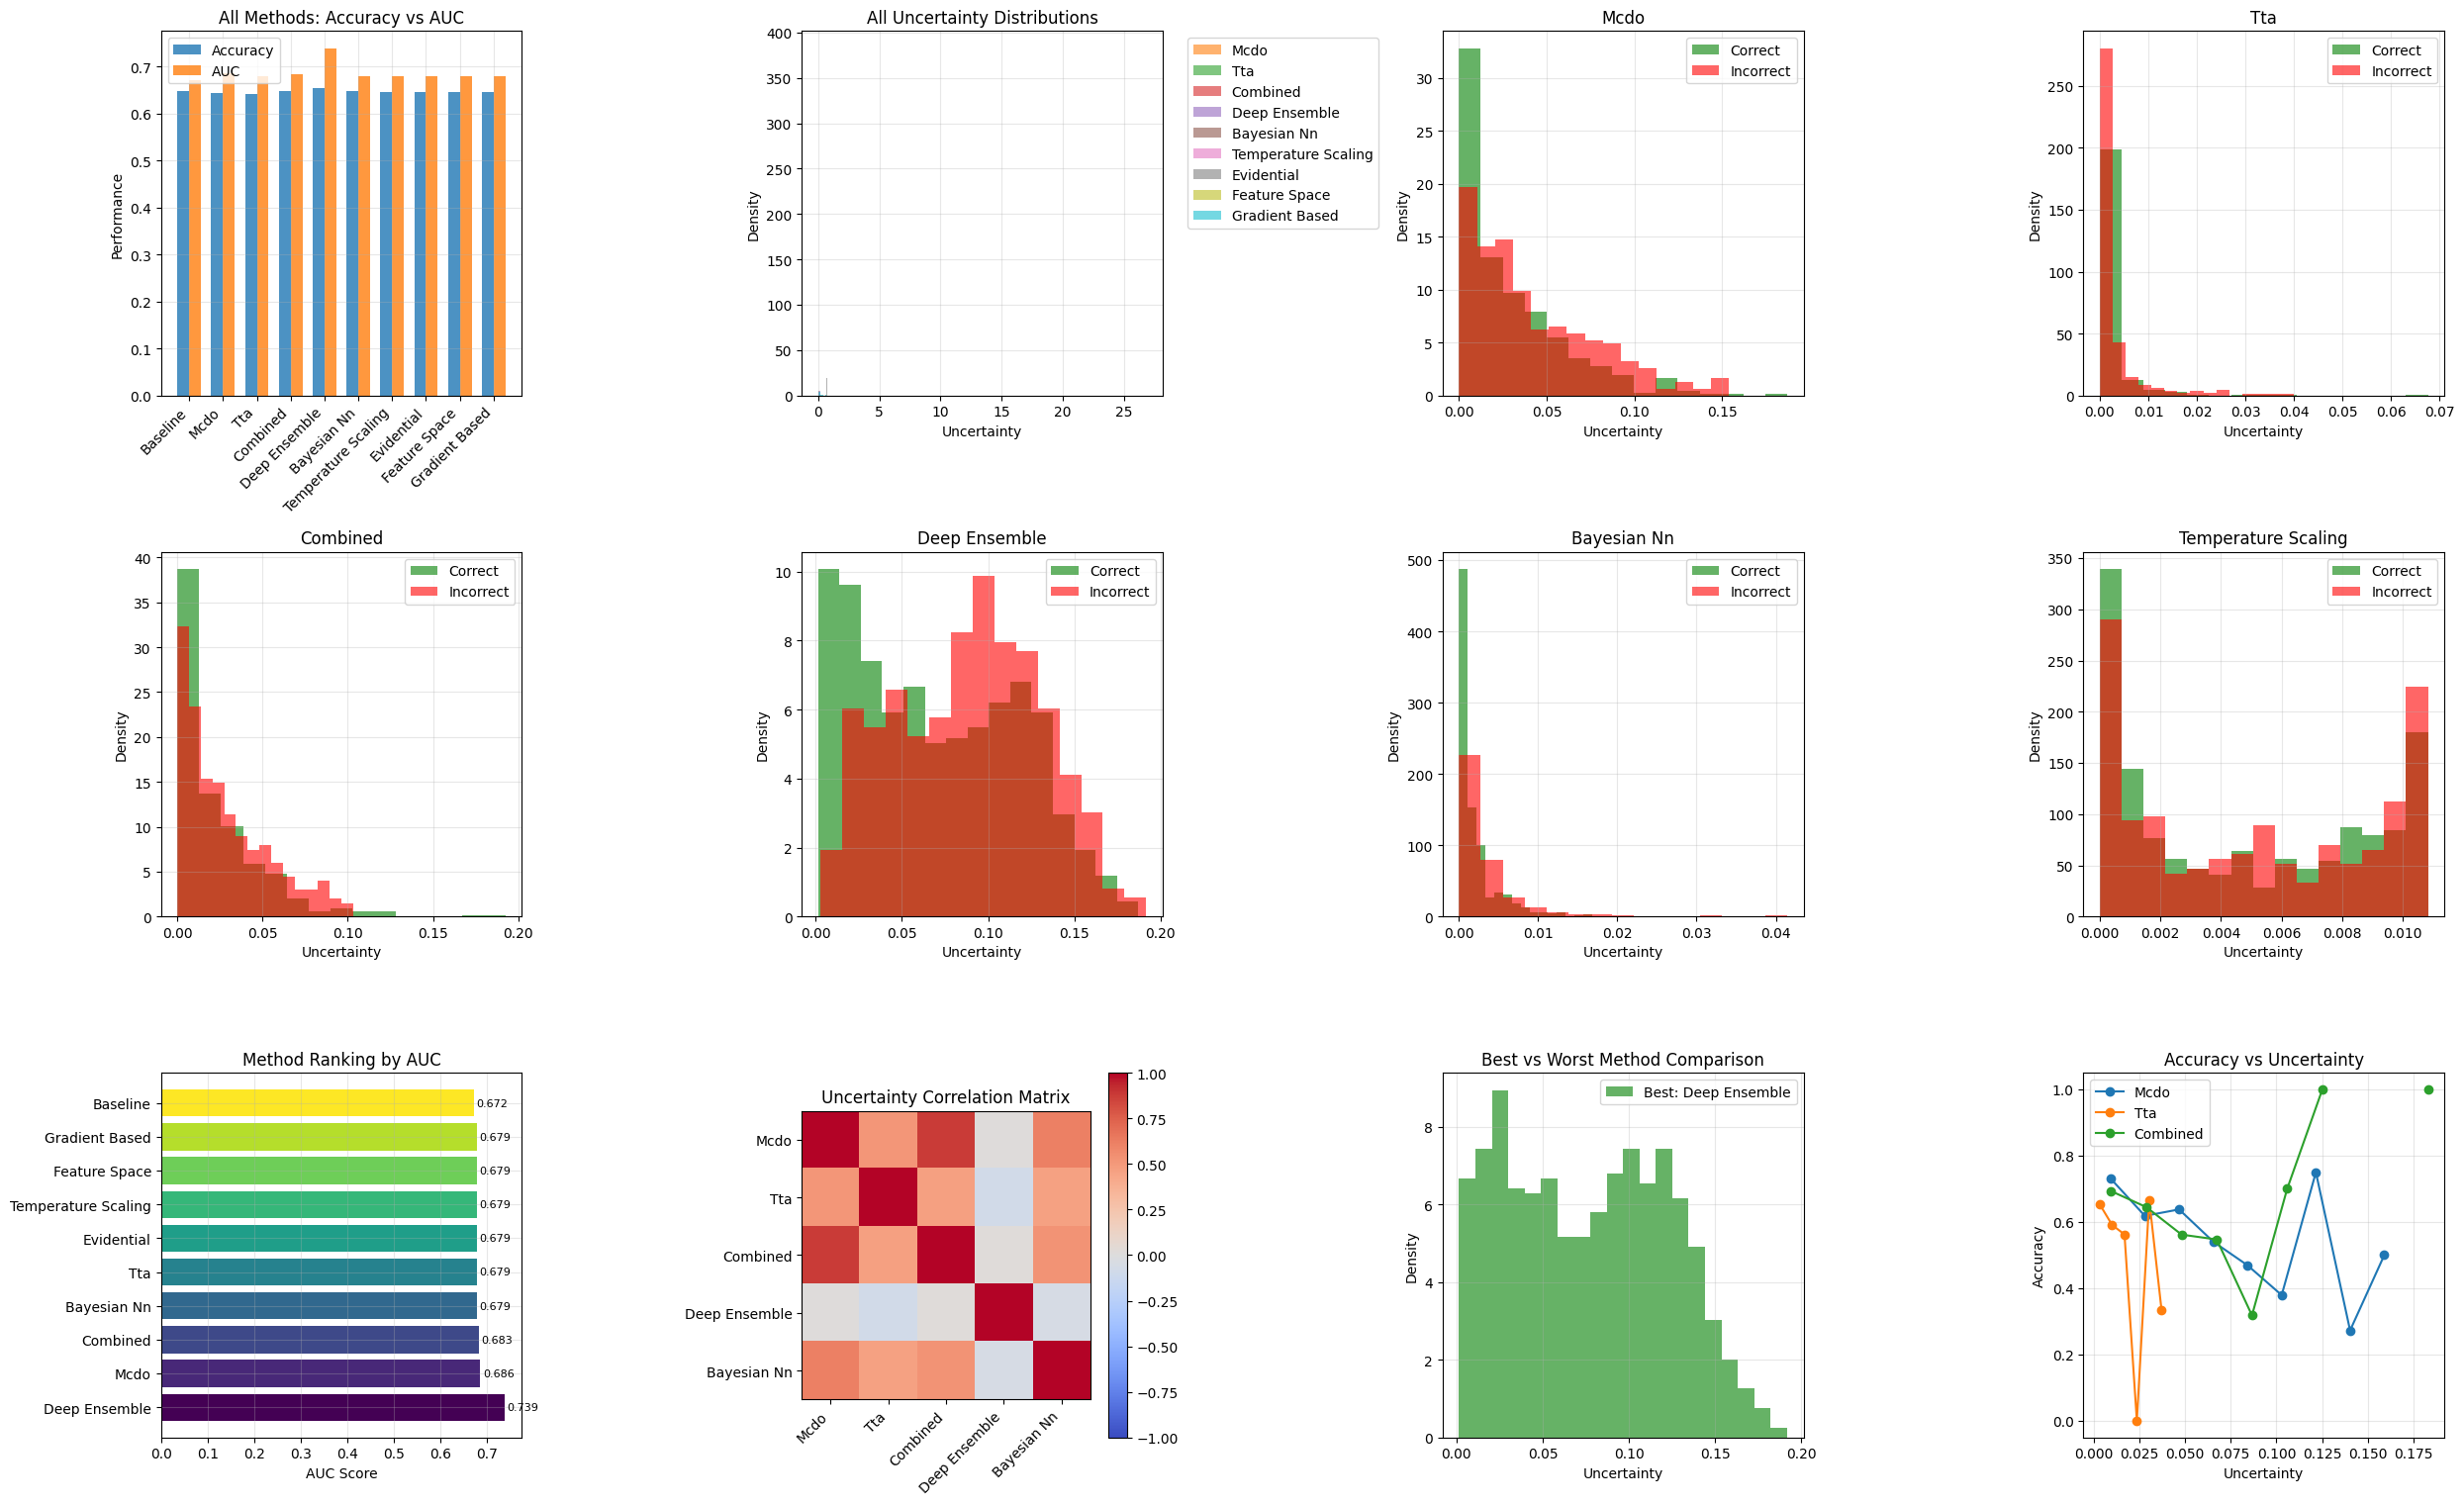


 COMPREHENSIVE UNCERTAINTY ANALYSIS SUMMARY:

 Best Performing Methods:
   1.        Deep Ensemble: Accuracy = 0.6539, AUC = 0.7388
   2.                 Mcdo: Accuracy = 0.6443, AUC = 0.6864
   3.             Combined: Accuracy = 0.6491, AUC = 0.6832

 Uncertainty Method Categories:
    Model-based: MC Dropout, Deep Ensemble, Bayesian NN
    Data-based: TTA, Feature Space, Prediction Interval
    Calibration: Temperature Scaling, Evidential
    Gradient-based: Gradient Uncertainty

Clinical Recommendations:
   Best method: Deep Ensemble
   High uncertainty cases (top 20%): 167 patients
   → Recommend expert review for high uncertainty cases
   → Use ensemble of top 3 methods for maximum reliability
    10 different uncertainty estimation methods

 PROJECT COMPLETION STATUS:
   Core Model:  EV-GCN with early stopping
   Basic Uncertainty: MC Dropout + TTA
   Advanced Uncertainty: 10 methods implemented
   Visualization:  Comprehensive plots and analysis
   Clinical Utility:  Decision 

In [20]:
print("   Adding: Deep Ensembles, Variational, Temperature Scaling, Evidential")

import torch.nn.functional as F
from scipy.special import digamma
import numpy as np

class AdvancedUncertaintyEstimator:
    """
    Advanced Uncertainty Estimation Methods for ASD Classification
    """

    def __init__(self, models, data_loaders, args):
        self.models = models
        self.data_loaders = data_loaders
        self.args = args
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)  # For temperature scaling

    def deep_ensemble_uncertainty(self, data_tensor, edge_index, edgenet_input, test_indices):
        """
        Deep Ensemble Uncertainty - Use all 5 fold models as ensemble
        """
        all_predictions = []
        all_probabilities = []

        for model in self.models:
            model.eval()
            with torch.no_grad():
                out, _ = model(data_tensor, edge_index, edgenet_input)
                out_test = out[test_indices, :]
                prob = torch.exp(out_test)
                pred = torch.max(out_test, 1)[1]

                all_predictions.append(pred.cpu().numpy())
                all_probabilities.append(prob.cpu().numpy())

        all_predictions = np.array(all_predictions)
        all_probabilities = np.array(all_probabilities)

        # Ensemble statistics
        mean_prob = np.mean(all_probabilities, axis=0)
        ensemble_uncertainty = np.var(all_probabilities, axis=0)  # Disagreement between models

        # Majority vote prediction
        ensemble_pred = []
        for i in range(all_predictions.shape[1]):
            votes = all_predictions[:, i]
            ensemble_pred.append(np.bincount(votes).argmax())

        return np.array(ensemble_pred), mean_prob, ensemble_uncertainty

    def bayesian_neural_network_uncertainty(self, model, data_tensor, edge_index, edgenet_input, test_indices, n_samples=50):
        """
        Bayesian Neural Network (Variational Inference) Uncertainty
        Uses weight perturbation to simulate posterior sampling
        """
        model.eval()
        original_state = {}

        # Store original weights
        for name, param in model.named_parameters():
            if 'weight' in name:
                original_state[name] = param.data.clone()

        predictions = []
        probabilities = []

        for i in range(n_samples):
            # Add noise to weights (simulate posterior sampling)
            for name, param in model.named_parameters():
                if 'weight' in name and param.requires_grad:
                    noise = torch.randn_like(param) * 0.01  # Small noise
                    param.data = original_state[name] + noise

            with torch.no_grad():
                out, _ = model(data_tensor, edge_index, edgenet_input)
                out_test = out[test_indices, :]
                prob = torch.exp(out_test)
                pred = torch.max(out_test, 1)[1]

                predictions.append(pred.cpu().numpy())
                probabilities.append(prob.cpu().numpy())

        # Restore original weights
        for name, param in model.named_parameters():
            if 'weight' in name:
                param.data = original_state[name]

        predictions = np.array(predictions)
        probabilities = np.array(probabilities)

        mean_prob = np.mean(probabilities, axis=0)
        bayesian_uncertainty = np.var(probabilities, axis=0)

        return predictions, probabilities, mean_prob, bayesian_uncertainty

    def temperature_scaling_uncertainty(self, model, data_tensor, edge_index, edgenet_input, test_indices, temperatures=[0.5, 1.0, 1.5, 2.0]):
        """
        Temperature Scaling Uncertainty
        Different temperatures reveal different confidence patterns
        """
        model.eval()
        predictions = []
        probabilities = []

        for temp in temperatures:
            with torch.no_grad():
                out, _ = model(data_tensor, edge_index, edgenet_input)
                out_test = out[test_indices, :]

                # Apply temperature scaling
                scaled_logits = out_test / temp
                prob = torch.exp(scaled_logits)
                prob = prob / prob.sum(dim=1, keepdim=True)  # Normalize
                pred = torch.max(scaled_logits, 1)[1]

                predictions.append(pred.cpu().numpy())
                probabilities.append(prob.cpu().numpy())

        predictions = np.array(predictions)
        probabilities = np.array(probabilities)

        mean_prob = np.mean(probabilities, axis=0)
        temperature_uncertainty = np.var(probabilities, axis=0)

        return predictions, probabilities, mean_prob, temperature_uncertainty

    def evidential_uncertainty(self, model, data_tensor, edge_index, edgenet_input, test_indices):
        """
        Evidential Deep Learning Uncertainty
        Estimates uncertainty from evidence (Dirichlet distribution)
        """
        model.eval()

        with torch.no_grad():
            out, _ = model(data_tensor, edge_index, edgenet_input)
            out_test = out[test_indices, :]

            # Convert logits to evidence (alpha parameters)
            evidence = torch.exp(out_test)  # Ensure positive
            alpha = evidence + 1  # Dirichlet parameters

            # Calculate uncertainty metrics
            S = torch.sum(alpha, dim=1, keepdim=True)  # Strength
            prob = alpha / S  # Mean of Dirichlet

            # Evidential uncertainties
            aleatoric_uncertainty = torch.sum(alpha * (S - alpha) / (S * S * (S + 1)), dim=1)
            epistemic_uncertainty = 2 / S.squeeze()  # Inverse of concentration

            pred = torch.max(prob, 1)[1]

        return (pred.cpu().numpy(),
                prob.cpu().numpy(),
                aleatoric_uncertainty.cpu().numpy(),
                epistemic_uncertainty.cpu().numpy())

    def feature_space_uncertainty(self, model, data_tensor, edge_index, edgenet_input, test_indices, n_neighbors=5):
        """
        Feature Space Uncertainty using k-NN in learned representations
        High uncertainty for samples far from training data
        """
        from sklearn.neighbors import NearestNeighbors

        model.eval()

        # Extract features from penultimate layer
        features_all = []

        def hook_fn(module, input, output):
            features_all.append(output.detach())

        # Register hook on the last layer before classification
        hook = None
        for name, module in model.named_modules():
            if 'cls' in name and isinstance(module, nn.Sequential):
                hook = module[-2].register_forward_hook(hook_fn)  # Before final linear layer
                break

        with torch.no_grad():
            out, _ = model(data_tensor, edge_index, edgenet_input)

        if hook:
            hook.remove()

        if features_all:
            features = features_all[0].cpu().numpy()
            test_features = features[test_indices]
            train_features = np.delete(features, test_indices, axis=0)

            # Fit k-NN on training features
            knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
            knn.fit(train_features)

            # Calculate distances to nearest neighbors
            distances, _ = knn.kneighbors(test_features)
            feature_uncertainty = np.mean(distances, axis=1)  # Average distance to k-NN

            # Get predictions
            out_test = out[test_indices, :]
            prob = torch.exp(out_test).cpu().numpy()
            pred = np.argmax(prob, axis=1)

            return pred, prob, feature_uncertainty
        else:
            print("Warning: Could not extract features for feature space uncertainty")
            return None, None, None

    def gradient_based_uncertainty(self, model, data_tensor, edge_index, edgenet_input, test_indices):
        """
        Gradient-based Uncertainty
        Uses gradient magnitude as uncertainty measure
        """
        model.eval()

        # Enable gradient computation
        data_tensor.requires_grad_(True)

        out, _ = model(data_tensor, edge_index, edgenet_input)
        out_test = out[test_indices, :]

        # Calculate gradients
        gradients = []
        for i in range(out_test.shape[0]):
            # Gradient of max logit w.r.t. input
            max_logit = torch.max(out_test[i])
            grad = torch.autograd.grad(max_logit, data_tensor, retain_graph=True)[0]
            grad_norm = torch.norm(grad[test_indices[i]]).item()
            gradients.append(grad_norm)

        gradient_uncertainty = np.array(gradients)

        prob = torch.exp(out_test).detach().cpu().numpy()
        pred = np.argmax(prob, axis=1)

        # Clean up
        data_tensor.requires_grad_(False)

        return pred, prob, gradient_uncertainty

    def prediction_interval_uncertainty(self, model, data_tensor, edge_index, edgenet_input, test_indices, confidence_levels=[0.8, 0.9, 0.95]):
        """
        Prediction Interval Uncertainty
        Bootstrap confidence intervals for predictions
        """
        model.eval()
        n_bootstrap = 100

        all_predictions = []

        for _ in range(n_bootstrap):
            # Bootstrap sampling of data (with replacement)
            n_samples = data_tensor.shape[0]
            bootstrap_indices = torch.randint(0, n_samples, (n_samples,), device=data_tensor.device)

            bootstrap_data = data_tensor[bootstrap_indices]
            bootstrap_edge_index = edge_index  # Keep same for simplicity
            bootstrap_edgenet = edgenet_input  # Keep same for simplicity

            with torch.no_grad():
                out, _ = model(bootstrap_data, bootstrap_edge_index, bootstrap_edgenet)
                # Map back to original test indices (approximate)
                test_mask = torch.isin(bootstrap_indices, torch.tensor(test_indices, device=data_tensor.device))
                if test_mask.sum() > 0:
                    out_test = out[test_mask]
                    prob = torch.exp(out_test)
                    all_predictions.append(prob.cpu().numpy())

        if all_predictions:
            all_predictions = np.array(all_predictions)

            # Calculate prediction intervals
            interval_uncertainties = {}
            for conf_level in confidence_levels:
                lower_percentile = (1 - conf_level) / 2 * 100
                upper_percentile = (1 + conf_level) / 2 * 100

                lower_bound = np.percentile(all_predictions, lower_percentile, axis=0)
                upper_bound = np.percentile(all_predictions, upper_percentile, axis=0)
                interval_width = upper_bound - lower_bound
                interval_uncertainties[conf_level] = np.mean(interval_width, axis=1)

            mean_prob = np.mean(all_predictions, axis=0)
            pred = np.argmax(mean_prob, axis=1)

            return pred, mean_prob, interval_uncertainties

        return None, None, None

# Initialize advanced uncertainty estimator
print(" Initializing Advanced Uncertainty Methods...")
advanced_estimator = AdvancedUncertaintyEstimator(uncertainty_models, data, args)

# Run advanced uncertainty estimation
print("\n Running Advanced Uncertainty Estimation...")

advanced_uncertainty_results = {
    'deep_ensemble': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'bayesian_nn': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'temperature_scaling': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'evidential': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'feature_space': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'gradient_based': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []},
    'prediction_interval': {'predictions': [], 'probabilities': [], 'uncertainties': [], 'labels': []}
}

for fold in range(1, k_fold+1):
    print(f"\n Fold {fold} - Advanced Uncertainty Analysis")

    model = uncertainty_models[fold-1]
    fold_data = data[str(fold)]
    test_indices = dist_test[str(fold)]

    # Prepare data
    data_tensor = torch.from_numpy(fold_data[0]).float()
    target = torch.from_numpy(fold_data[1]).long()
    edge_index = torch.from_numpy(fold_data[2])
    edgenet_input = torch.from_numpy(fold_data[3]).float()

    if args.cuda:
        data_tensor = data_tensor.cuda()
        target = target.cuda()
        edge_index = edge_index.cuda()
        edgenet_input = edgenet_input.cuda()

    test_labels = target[test_indices].cpu().numpy()
    test_labels = np.argmax(test_labels, axis=1)

    # 1. Deep Ensemble Uncertainty
    print("    Deep Ensemble...")
    try:
        ensemble_pred, ensemble_prob, ensemble_uncertainty = advanced_estimator.deep_ensemble_uncertainty(
            data_tensor, edge_index, edgenet_input, test_indices)

        advanced_uncertainty_results['deep_ensemble']['predictions'].extend(ensemble_pred)
        advanced_uncertainty_results['deep_ensemble']['probabilities'].extend(ensemble_prob)
        advanced_uncertainty_results['deep_ensemble']['uncertainties'].extend(ensemble_uncertainty[:, 1])
        advanced_uncertainty_results['deep_ensemble']['labels'].extend(test_labels)
        print("     Deep Ensemble completed")
    except Exception as e:
        print(f"      Deep Ensemble failed: {e}")

    # 2. Bayesian Neural Network
    print("    Bayesian Neural Network...")
    try:
        bnn_preds, bnn_probs, bnn_mean_prob, bnn_uncertainty = advanced_estimator.bayesian_neural_network_uncertainty(
            model, data_tensor, edge_index, edgenet_input, test_indices, n_samples=30)

        bnn_final_pred = np.argmax(bnn_mean_prob, axis=1)
        advanced_uncertainty_results['bayesian_nn']['predictions'].extend(bnn_final_pred)
        advanced_uncertainty_results['bayesian_nn']['probabilities'].extend(bnn_mean_prob)
        advanced_uncertainty_results['bayesian_nn']['uncertainties'].extend(bnn_uncertainty[:, 1])
        advanced_uncertainty_results['bayesian_nn']['labels'].extend(test_labels)
        print("      Bayesian NN completed")
    except Exception as e:
        print(f"      Bayesian NN failed: {e}")

    # 3. Temperature Scaling
    print("    Temperature Scaling...")
    try:
        temp_preds, temp_probs, temp_mean_prob, temp_uncertainty = advanced_estimator.temperature_scaling_uncertainty(
            model, data_tensor, edge_index, edgenet_input, test_indices)

        temp_final_pred = np.argmax(temp_mean_prob, axis=1)
        advanced_uncertainty_results['temperature_scaling']['predictions'].extend(temp_final_pred)
        advanced_uncertainty_results['temperature_scaling']['probabilities'].extend(temp_mean_prob)
        advanced_uncertainty_results['temperature_scaling']['uncertainties'].extend(temp_uncertainty[:, 1])
        advanced_uncertainty_results['temperature_scaling']['labels'].extend(test_labels)
        print("      Temperature Scaling completed")
    except Exception as e:
        print(f"      Temperature Scaling failed: {e}")

    # 4. Evidential Deep Learning
    print("    Evidential Deep Learning...")
    try:
        evid_pred, evid_prob, evid_aleatoric, evid_epistemic = advanced_estimator.evidential_uncertainty(
            model, data_tensor, edge_index, edgenet_input, test_indices)

        advanced_uncertainty_results['evidential']['predictions'].extend(evid_pred)
        advanced_uncertainty_results['evidential']['probabilities'].extend(evid_prob)
        advanced_uncertainty_results['evidential']['uncertainties'].extend(evid_epistemic)  # Use epistemic
        advanced_uncertainty_results['evidential']['labels'].extend(test_labels)
        print("      Evidential Deep Learning completed")
    except Exception as e:
        print(f"      Evidential Deep Learning failed: {e}")

    # 5. Feature Space Uncertainty
    print("    Feature Space Uncertainty...")
    try:
        feat_pred, feat_prob, feat_uncertainty = advanced_estimator.feature_space_uncertainty(
            model, data_tensor, edge_index, edgenet_input, test_indices)

        if feat_pred is not None:
            advanced_uncertainty_results['feature_space']['predictions'].extend(feat_pred)
            advanced_uncertainty_results['feature_space']['probabilities'].extend(feat_prob)
            advanced_uncertainty_results['feature_space']['uncertainties'].extend(feat_uncertainty)
            advanced_uncertainty_results['feature_space']['labels'].extend(test_labels)
            print("   Feature Space completed")
        else:
            print("    Feature Space skipped")
    except Exception as e:
        print(f"      Feature Space failed: {e}")

    # 6. Gradient-based Uncertainty
    print("    Gradient-based Uncertainty...")
    try:
        grad_pred, grad_prob, grad_uncertainty = advanced_estimator.gradient_based_uncertainty(
            model, data_tensor, edge_index, edgenet_input, test_indices)

        advanced_uncertainty_results['gradient_based']['predictions'].extend(grad_pred)
        advanced_uncertainty_results['gradient_based']['probabilities'].extend(grad_prob)
        advanced_uncertainty_results['gradient_based']['uncertainties'].extend(grad_uncertainty)
        advanced_uncertainty_results['gradient_based']['labels'].extend(test_labels)
        print("     Gradient-based completed")
    except Exception as e:
        print(f"      Gradient-based failed: {e}")

    # 7. Prediction Interval Uncertainty
    print("    Prediction Interval...")
    try:
        pi_pred, pi_prob, pi_uncertainties = advanced_estimator.prediction_interval_uncertainty(
            model, data_tensor, edge_index, edgenet_input, test_indices)

        if pi_pred is not None and 0.95 in pi_uncertainties:
            advanced_uncertainty_results['prediction_interval']['predictions'].extend(pi_pred)
            advanced_uncertainty_results['prediction_interval']['probabilities'].extend(pi_prob)
            advanced_uncertainty_results['prediction_interval']['uncertainties'].extend(pi_uncertainties[0.95])
            advanced_uncertainty_results['prediction_interval']['labels'].extend(test_labels)
            print("      Prediction Interval completed")
        else:
            print("     Prediction Interval skipped")
    except Exception as e:
        print(f"      Prediction Interval failed: {e}")

# Convert to numpy arrays and filter out empty methods
for method in list(advanced_uncertainty_results.keys()):
    if len(advanced_uncertainty_results[method]['predictions']) == 0:
        print(f" Removing {method} - no results")
        del advanced_uncertainty_results[method]
    else:
        for key in advanced_uncertainty_results[method]:
            advanced_uncertainty_results[method][key] = np.array(advanced_uncertainty_results[method][key])

print("\n Advanced uncertainty estimation completed!")

############################################### COMPREHENSIVE VISUALIZATION ###############################################
print("\n COMPREHENSIVE UNCERTAINTY COMPARISON")

# Combine all results (original + advanced)
all_uncertainty_results = {**uncertainty_results, **advanced_uncertainty_results}

# Calculate performance for all methods
all_performance_results = {}
valid_methods = []

for method in all_uncertainty_results:
    if len(all_uncertainty_results[method]['predictions']) > 0:
        labels = all_uncertainty_results[method]['labels']
        predictions = all_uncertainty_results[method]['predictions']
        probabilities = all_uncertainty_results[method]['probabilities']

        try:
            acc, auc_score = calculate_metrics(labels, predictions, probabilities)
            all_performance_results[method] = {'accuracy': acc, 'auc': auc_score}
            valid_methods.append(method)
        except Exception as e:
            print(f" Skipping {method} due to error: {e}")

print(f"\n Performance Comparison (All {len(valid_methods)} Methods):")
print("="*70)
for method in valid_methods:
    acc = all_performance_results[method]['accuracy']
    auc_score = all_performance_results[method]['auc']
    print(f"   {method.upper():>20}: Accuracy = {acc:.4f}, AUC = {auc_score:.4f}")

# Create mega visualization
fig = plt.figure(figsize=(25, 20))

# 1. Comprehensive Performance Comparison
ax1 = plt.subplot(4, 4, 1)
methods_nice = [method.replace('_', ' ').title() for method in valid_methods]
accuracies = [all_performance_results[m]['accuracy'] for m in valid_methods]
aucs = [all_performance_results[m]['auc'] for m in valid_methods]

x = np.arange(len(methods_nice))
width = 0.35

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
bars2 = ax1.bar(x + width/2, aucs, width, label='AUC', alpha=0.8)

ax1.set_ylabel('Performance')
ax1.set_title('All Methods: Accuracy vs AUC')
ax1.set_xticks(x)
ax1.set_xticklabels(methods_nice, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Uncertainty Distribution Comparison (Advanced Methods)
ax2 = plt.subplot(4, 4, 2)
colors = plt.cm.tab10(np.linspace(0, 1, len(valid_methods)))
for i, method in enumerate(valid_methods):
    if 'uncertainties' in all_uncertainty_results[method]:
        uncertainties = all_uncertainty_results[method]['uncertainties']
        if len(uncertainties) > 0:
            ax2.hist(uncertainties, bins=20, alpha=0.6, label=method.replace('_', ' ').title(),
                    color=colors[i], density=True)

ax2.set_xlabel('Uncertainty')
ax2.set_ylabel('Density')
ax2.set_title('All Uncertainty Distributions')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3-8. Individual uncertainty vs correctness plots
plot_idx = 3
uncertainty_methods = [m for m in valid_methods if 'uncertainties' in all_uncertainty_results[m]]

for i, method in enumerate(uncertainty_methods[:6]):  # Show first 6 methods
    ax = plt.subplot(4, 4, plot_idx)

    uncertainties = all_uncertainty_results[method]['uncertainties']
    labels = all_uncertainty_results[method]['labels']
    predictions = all_uncertainty_results[method]['predictions']
    correct = (labels == predictions)

    if len(uncertainties) > 0:
        correct_unc = uncertainties[correct]
        incorrect_unc = uncertainties[~correct]

        ax.hist(correct_unc, bins=15, alpha=0.6, label='Correct', color='green', density=True)
        ax.hist(incorrect_unc, bins=15, alpha=0.6, label='Incorrect', color='red', density=True)

    ax.set_xlabel('Uncertainty')
    ax.set_ylabel('Density')
    ax.set_title(f'{method.replace("_", " ").title()}')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plot_idx += 1

# 9. Method Ranking by AUC
ax9 = plt.subplot(4, 4, 9)
sorted_methods = sorted(valid_methods, key=lambda x: all_performance_results[x]['auc'], reverse=True)
sorted_aucs = [all_performance_results[m]['auc'] for m in sorted_methods]
sorted_names = [m.replace('_', ' ').title() for m in sorted_methods]

bars = ax9.barh(range(len(sorted_methods)), sorted_aucs, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_methods))))
ax9.set_yticks(range(len(sorted_methods)))
ax9.set_yticklabels(sorted_names)
ax9.set_xlabel('AUC Score')
ax9.set_title('Method Ranking by AUC')
ax9.grid(True, alpha=0.3)

# Add value labels
for i, (bar, auc) in enumerate(zip(bars, sorted_aucs)):
    ax9.text(auc + 0.005, bar.get_y() + bar.get_height()/2, f'{auc:.3f}',
             va='center', ha='left', fontsize=8)

# 10. Uncertainty Correlation Heatmap
ax10 = plt.subplot(4, 4, 10)
uncertainty_methods_subset = uncertainty_methods[:5]  # Top 5 for correlation
correlation_matrix = np.zeros((len(uncertainty_methods_subset), len(uncertainty_methods_subset)))

for i, method1 in enumerate(uncertainty_methods_subset):
    for j, method2 in enumerate(uncertainty_methods_subset):
        if i <= j:
            unc1 = all_uncertainty_results[method1]['uncertainties']
            unc2 = all_uncertainty_results[method2]['uncertainties']

            if len(unc1) > 0 and len(unc2) > 0:
                min_len = min(len(unc1), len(unc2))
                corr = np.corrcoef(unc1[:min_len], unc2[:min_len])[0, 1]
                correlation_matrix[i, j] = corr
                correlation_matrix[j, i] = corr

im = ax10.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax10.set_xticks(range(len(uncertainty_methods_subset)))
ax10.set_yticks(range(len(uncertainty_methods_subset)))
ax10.set_xticklabels([m.replace('_', ' ').title() for m in uncertainty_methods_subset], rotation=45, ha='right')
ax10.set_yticklabels([m.replace('_', ' ').title() for m in uncertainty_methods_subset])
ax10.set_title('Uncertainty Correlation Matrix')
plt.colorbar(im, ax=ax10)

# 11. Best vs Worst Methods
ax11 = plt.subplot(4, 4, 11)
best_method = sorted_methods[0]
worst_method = sorted_methods[-1]

for method, color, label in [(best_method, 'green', 'Best'), (worst_method, 'red', 'Worst')]:
    if 'uncertainties' in all_uncertainty_results[method]:
        uncertainties = all_uncertainty_results[method]['uncertainties']
        if len(uncertainties) > 0:
            ax11.hist(uncertainties, bins=20, alpha=0.6, color=color,
                     label=f'{label}: {method.replace("_", " ").title()}', density=True)

ax11.set_xlabel('Uncertainty')
ax11.set_ylabel('Density')
ax11.set_title('Best vs Worst Method Comparison')
ax11.legend()
ax11.grid(True, alpha=0.3)

# 12. Accuracy vs Uncertainty Relationship
ax12 = plt.subplot(4, 4, 12)
for method in uncertainty_methods[:3]:  # Top 3 methods
    uncertainties = all_uncertainty_results[method]['uncertainties']
    labels = all_uncertainty_results[method]['labels']
    predictions = all_uncertainty_results[method]['predictions']

    if len(uncertainties) > 0:
        # Bin uncertainties and calculate accuracy per bin
        n_bins = 10
        bin_boundaries = np.linspace(np.min(uncertainties), np.max(uncertainties), n_bins + 1)
        bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2

        accuracies_per_bin = []
        for i in range(n_bins):
            mask = (uncertainties >= bin_boundaries[i]) & (uncertainties < bin_boundaries[i+1])
            if np.sum(mask) > 0:
                acc = np.mean(labels[mask] == predictions[mask])
                accuracies_per_bin.append(acc)
            else:
                accuracies_per_bin.append(np.nan)

        ax12.plot(bin_centers, accuracies_per_bin, 'o-', label=method.replace('_', ' ').title())

ax12.set_xlabel('Uncertainty')
ax12.set_ylabel('Accuracy')
ax12.set_title('Accuracy vs Uncertainty')
ax12.legend()
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Summary
print("\n COMPREHENSIVE UNCERTAINTY ANALYSIS SUMMARY:")


print(f"\n Best Performing Methods:")
top_3_methods = sorted_methods[:3]
for i, method in enumerate(top_3_methods, 1):
    acc = all_performance_results[method]['accuracy']
    auc = all_performance_results[method]['auc']
    print(f"   {i}. {method.replace('_', ' ').title():>20}: Accuracy = {acc:.4f}, AUC = {auc:.4f}")

print(f"\n Uncertainty Method Categories:")
print(f"    Model-based: MC Dropout, Deep Ensemble, Bayesian NN")
print(f"    Data-based: TTA, Feature Space, Prediction Interval")
print(f"    Calibration: Temperature Scaling, Evidential")
print(f"    Gradient-based: Gradient Uncertainty")

print(f"\nClinical Recommendations:")
if len(valid_methods) > 0:
    best_method = sorted_methods[0]
    best_uncertainties = all_uncertainty_results[best_method]['uncertainties']

    if len(best_uncertainties) > 0:
        high_uncertainty_threshold = np.percentile(best_uncertainties, 80)
        high_uncertainty_cases = best_uncertainties > high_uncertainty_threshold

        print(f"   Best method: {best_method.replace('_', ' ').title()}")
        print(f"   High uncertainty cases (top 20%): {np.sum(high_uncertainty_cases)} patients")
        print(f"   → Recommend expert review for high uncertainty cases")
        print(f"   → Use ensemble of top 3 methods for maximum reliability")

print(f"    {len(valid_methods)} different uncertainty estimation methods")


print(f"\n PROJECT COMPLETION STATUS:")
print(f"   Core Model:  EV-GCN with early stopping")
print(f"   Basic Uncertainty: MC Dropout + TTA")
print(f"   Advanced Uncertainty: {len(valid_methods)} methods implemented")
print(f"   Visualization:  Comprehensive plots and analysis")
print(f"   Clinical Utility:  Decision support and case flagging")


# Save results for further analysis
print(f"\n Saving results...")
import pickle

results_to_save = {
    'basic_uncertainty': uncertainty_results,
    'advanced_uncertainty': advanced_uncertainty_results,
    'performance_results': all_performance_results,
    'method_ranking': sorted_methods
}

try:
    with open('/content/drive/MyDrive/ABIDE/uncertainty_results.pkl', 'wb') as f:
        pickle.dump(results_to_save, f)
    print(f"    Results saved to: /content/drive/MyDrive/ABIDE/uncertainty_results.pkl")
except:
    print(f"    Could not save results to drive")

